# Código Gráficas de Comparación 
(Observado, Pronóstico y Nuevo Pronóstico)

## Cargar Librerias
Se cargan las librerías esenciales para la manipulación de datos, visualización, cálculos numéricos, manejo de fechas, interacción con la web y operaciones del sistema operativo.

In [217]:
#cargas librerias necesarias
import matplotlib.pyplot as plt # Para visualización de datos en 2D.
import pandas as pd  # Para manipulación de datos.
import numpy as np  # Para cálculos numéricos.
from datetime import datetime, date, timedelta  # Importamos clases relacionadas con fechas y horas.
import os  # Para interactuar con el sistema operativo.

## Datos Prior

Cargar la fecha de la cual se desea cargar los datos y luego crear el grafico en formato datetime y texto ('YYYYMMDD')

In [218]:
fecha =  date.today() - timedelta(days=1)
fecha_txt = fecha.strftime("%Y%m%d")
ano = fecha.year
mes = fecha.month

## Función para crear tablas de datos para graficar

La función `crear_tabla_si_no_existe` se encarga de crear una tabla en la carpeta especificada si esta no existe y luego la devuelve como un DataFrame. Esta función toma tres argumentos: `carpeta`, que es la ruta de la carpeta donde se guardará la tabla de resultados; `nombres`, que es una lista de nombres de las tablas a crear o abrir; y `tablas`, que es una lista de DataFrames de datos a cargar. La función verifica si la carpeta especificada existe, y si no existe, la crea.

La función itera a través de los nombres y tablas proporcionados. Para cada par de nombre y tabla, se construye la ruta completa del archivo que contendrá la tabla en formato CSV. Si el archivo no existe en esa ubicación, la tabla se crea y se guarda en ese archivo CSV. Si el archivo ya existe, se carga la tabla desde el archivo existente en formato CSV.

La función devuelve una lista de DataFrames que representan las tablas de resultados, ya sea las creadas o las abiertas desde archivos CSV.

In [219]:
def crear_tabla_si_no_existe(carpeta, nombres, tablas):
    """
    Crea una tabla si no existe en la carpeta especificada y la devuelve como un DataFrame.

    Args:
        carpeta (str): Ruta de la carpeta donde se guardará la tabla de resultados.
        nombres (list of str): Lista de nombres de las tablas a crear o abrir.
        tablas (list of pd.DataFrame): Lista de DataFrames de datos a cargar.

    Returns:
        list of pd.DataFrame: Lista de DataFrames de las tablas de resultados creadas o abiertas.
    """
    resultados = []

    # Verificar si la carpeta existe; si no existe, crearla
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)

    for nombre, tabla in zip(nombres, tablas):
        # Ruta completa del archivo que contendrá la tabla
        ruta_archivo = os.path.join(carpeta, f"{nombre}.csv")

        # Si el archivo no existe, se crea la tabla con todos los datos
        if not os.path.exists(ruta_archivo):
            resultado = tabla[["Estacion"]]
            resultados.append(resultado)
        else:
            # Si el archivo existe, se carga la tabla desde el archivo CSV
            data = pd.read_csv(ruta_archivo)
            resultados.append(data)

    return resultados

## Función para ajustar y fusionar tablas

La función `renombrar_y_fusionar_tablas` tiene como propósito principal ajustar las tablas de datos que se utilizarán en la generación de gráficos y fusionarlas en tablas de resultados de los datos a graficar. Para ello, toma varios argumentos, incluyendo la `carpeta` en la que se guardarán las tablas de resultados, la `fecha_txt` que representa la fecha en formato de texto de los datos utilizados, los `nombres` de las tablas de datos a graficar, las `tablas` que contienen los datos originales y los `resultados` que almacenan los datos a graficar.

El proceso que realiza la función implica iterar a través de las tablas, resultados y nombres proporcionados. Para cada par de tabla, resultado y nombre, la función cambia el nombre de las columnas de la tabla para que reflejen adecuadamente la fecha en los datos, lo que facilitará la diferenciación de los datos por día al realizar los gráficos. Luego, verifica si la columna con la fecha ya existe en la tabla de resultados; si es así, la elimina para evitar duplicados.

Uno de los aspectos clave de esta función es la fusión de las tablas. Combina la tabla que contiene los datos a graficar con las tablas de datos originales. Esta fusión se lleva a cabo utilizando la columna "Estacion" como clave y un método de unión externa ("outer"), lo que permite mantener todos los datos de ambas tablas en la tabla de resultados.

Una vez realizados estos pasos, la función guarda las tablas resultantes en formato CSV y TXT en la carpeta especificada. Cada tabla se guarda con el nombre correspondiente proporcionado en la lista de nombres. Además, las tablas actualizadas se almacenan en una nueva lista llamada `new_resultados`. La función devuelve la lista `new_resultados` que contiene las tablas con los datos a graficar.

In [220]:
def obtener_acumulado_tablas(carpeta, fecha_txt, nombres, tablas, resultados):
    """
    Ajusta las tablas de datos a graficar y las fusiona en tablas de resultados.

    Args:
        carpeta (str): Ruta de la carpeta donde se guardarán las tablas de resultados.
        fecha_txt (str): Fecha en formato texto de los datos que se estan utilizando.
        nombres (list of str): Lista de nombres de las tablas con los datos a graficar.
        tablas (list of pd.DataFrame): Lista que contiene las tablas con los datos originales.
        resultados (list of pd.DataFrame): Lista que contiene las tablas con los datos a graficar.

    Returns:
        list of pd.DataFrame: Lista de DataFrames de las tablas de resultados creadas o actualizadas.
    """
    
    
    new_resultados = []

    for tabla, resultado, nombre in zip(tablas, resultados, nombres):
        # Cambiar el nombre de las columnas para que a la hora de graficar se diferencien los datos por día
        tabla.columns = ['Estacion', fecha_txt]

        # Si la columna con la fecha a agregar ya existe en el resultado, eliminarla
        if fecha_txt in resultado.columns:
            resultado.drop(columns=[fecha_txt], inplace=True)

        # Verifica si 'resultado' tiene más de una columna
        if resultado.shape[1] > 1:
            # Realiza la operación cuando 'resultado' tiene más de una columna
            resultado[fecha_txt] = resultado.iloc[:, -1] + tabla[fecha_txt]
        else:
            # Realiza la operación cuando 'resultado' tiene una sola columna
            resultado[fecha_txt] = tabla[fecha_txt]

        # Guardar las tablas en formato CSV y TXT
        resultado.to_csv(f"{carpeta}/{nombre}.csv", index=False)
        resultado.to_csv(os.path.join(carpeta, f"{nombre}.txt"), index=False)

        # Guardar los resultados en la nueva lista
        new_resultados.append(resultado)

    return new_resultados

## Función para Graficar Lluvia

La función `graficar_datos` tiene como objetivo generar gráficos para cada estación, simultáneamente representando los resultados observados de las estaciones, pronosticados sin ajuste del WRF y pronosticados con ajuste del WRF. Para realizar esta tarea, recibe varios argumentos, entre ellos la `carpeta` donde se guardarán los gráficos, la lista de `resultados` que contiene las tablas con los datos a graficar, el título del eje Y (`ejey`).

La función comienza creando una lista de las estaciones que son comunes entre los tres conjuntos de tablas de resultados. Esto permite asegurar que las estaciones sean consistentes en todos los conjuntos de datos.

Luego, la función itera a través de cada estación común. Para cada estación, crea una figura y ejes utilizando Matplotlib, especificando un tamaño para el gráfico. Luego, se filtran las tablas de datos para obtener las observaciones, pronósticos sin ajustar y pronósticos ajustados por separado.

Los valores relevantes de cada conjunto de datos se extraen y se representan como barras en el gráfico. El título, etiquetas de ejes y otras características del gráfico se configuran adecuadamente. Se guarda el gráfico en un archivo en la carpeta especificada y se muestra en pantalla. Este proceso se repite para cada estación común, generando gráficos individuales.

In [221]:
def graficar_datos_acumulado_lluvia(carpeta, resultados, Label, mes, ano):
    # Crear una lista de las estaciones comunes entre los 3 conjuntos de tablas
    estaciones_comunes = set(resultados[0]['Estacion']).intersection(resultados[1]['Estacion'], resultados[2]['Estacion'])

    # Iterar sobre cada estación
    for estacion in estaciones_comunes:
        fig, ax = plt.subplots(figsize=(12, 8))  # Crea una figura y ejes

        # Iterar sobre cada tabla de datos (observado, pronóstico y nuevo pronóstico) y cada etiqueta
        for resultado, label in zip(resultados, Label):
            # Seleccionar la fila de datos correspondiente a la estación
            dato = resultado[resultado['Estacion'] == estacion]

            # Extraer las fechas y valores correspondientes a graficar
            fechas = dato.columns[1:]
            valores = dato.iloc[0, 1:].astype(float)

            # Crear un gráfico de dispersión con líneas para la estación actual con datos de las tres tablas
            ax.plot(fechas, valores, marker='o', linestyle='-', label=label)

        ax.set_title(f'Gráfico de Acumulado - Estación {estacion}')  # Asignar título de cada gráfico
        ax.set_xlabel('Fechas')  # Título del eje x
        ax.set_ylabel('Lluvia (mm)')  # Título del eje y
        ax.tick_params(axis='x', rotation=45)  # Rota las etiquetas del eje x para una mejor legibilidad
        ax.legend()  # Agrega una leyenda para identificar las tablas

        # Crear un nombre con el que se guardará cada gráfico
        nombre_archivo = os.path.join(carpeta, f'estacion_{estacion}_acumulado_mensual_{mes}_{ano}.png')

        # Guardar el gráfico en un archivo en la carpeta de destino
        plt.savefig(nombre_archivo)

        # Mostrar los gráficos
        plt.show()

## Datos de Lluvia

Se definen las rutas de tres archivos de datos de lluvia en una lista llamada `archivos_a_verificar_lluvia`. Cada ruta se compone de una ubicación en el sistema de archivos y se utiliza la variable `fecha_txt` para generar nombres de archivo especificos que queremos obtener.

Se utiliza una lista de comprensión para verificar si los archivos especificados en `archivos_a_verificar_lluvia` existen en el sistema. La lista `archivos_faltantes_lluvia` contendrá las rutas de los archivos que no se encuentren en el sistema. Esta verificación garantiza que los archivos necesarios estén disponibles antes de continuar con el procesamiento. Se verifica si la lista `archivos_faltantes_lluvia` está vacía. Si todos los archivos especificados existen, se procede al procesamiento de datos. Sin embargo, si faltan archivos, se muestra un mensaje que enumera los archivos que faltan y se le pide al usuario que verifique su existencia.

Si se confirma que todos los archivos especificados existen, se procede a realizar el procesamiento de datos de lluvia. En este punto, los archivos se leen utilizando la biblioteca Pandas y se almacenan en variables específicas como `lluvia_observado`, `lluvia_pronostico`, y `lluvia_newpronostico`. Además, se especifica la carpeta de destino donde se guardarán las gráficas y tablas relacionadas con los datos de lluvia.

Se crean varias variables y listas que se utilizarán en funciones posteriores. Estas incluyen `tablas_lluvia`, que es una lista que contiene las tres tablas de datos de lluvia a utilizar; `nombres_lluvia`, que es una lista con nombres de tablas a crear o abrir para almacenar los datos que se van a graficar; `label`, que es una lista de etiquetas para cada gráfica; y `ejey_lluvia`, que representa el título del eje Y de las gráficas, en este caso, "Lluvia (mm)".

Luego, se llaman una serie de funciones para realizar diversas tareas. La función `crear_tabla_si_no_existe` se llama para crear o abrir tablas que almacenarán los datos de lluvia a graficar. Luego, se llama a la función `renombrar_y_fusionar_tablas` para editar y fusionar las tablas de datos de lluvia. Finalmente, se llama a la función `graficar_datos` para generar gráficas de los datos de lluvia utilizando los resultados de las operaciones anteriores.

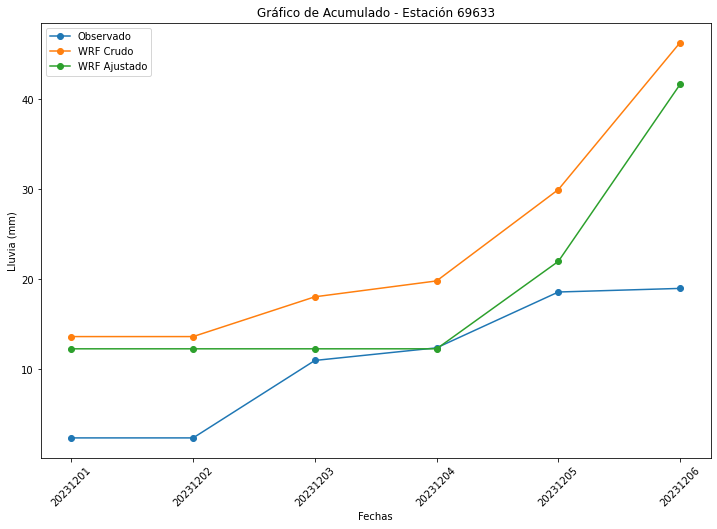

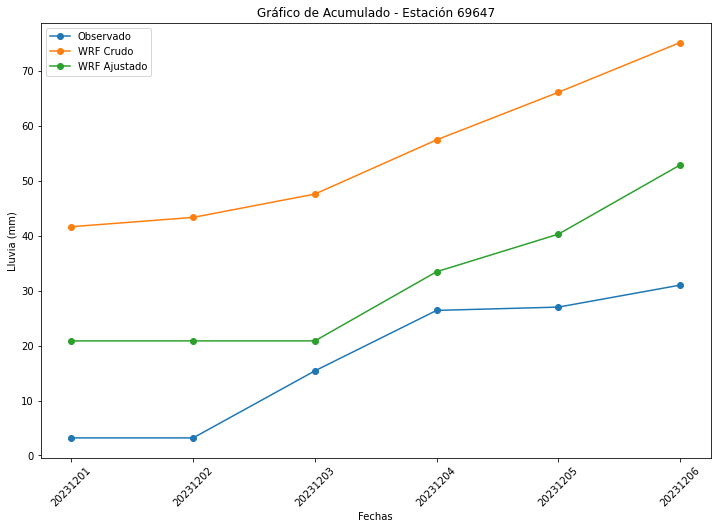

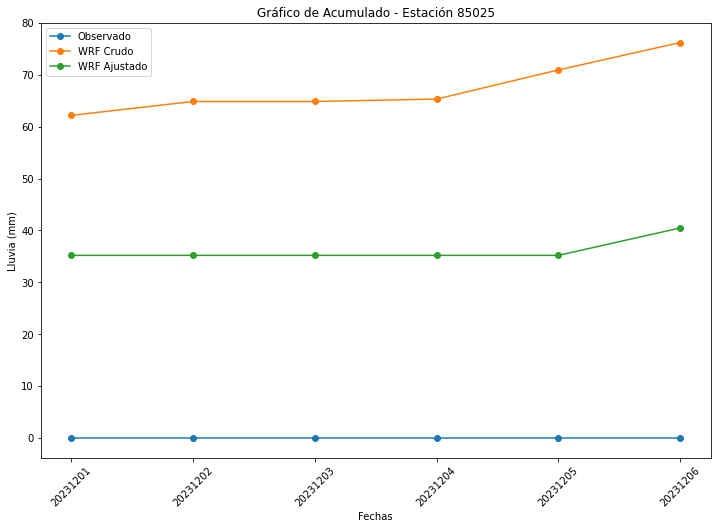

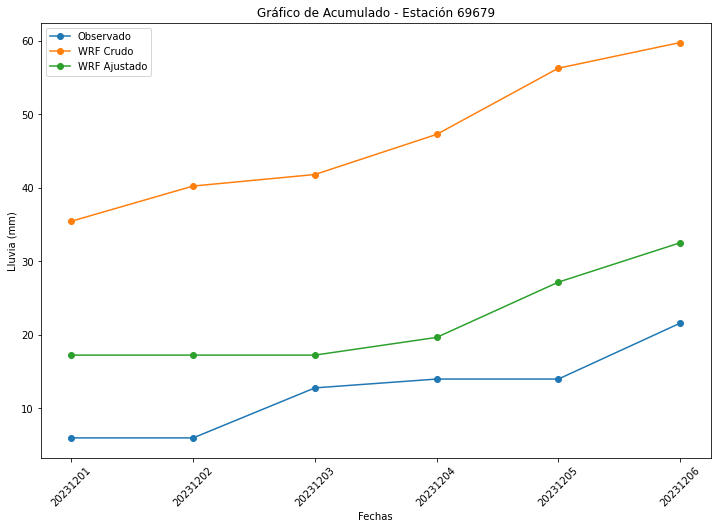

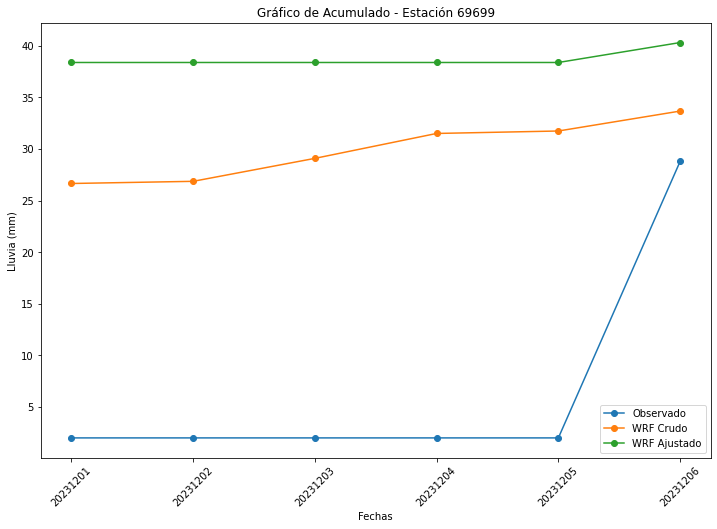

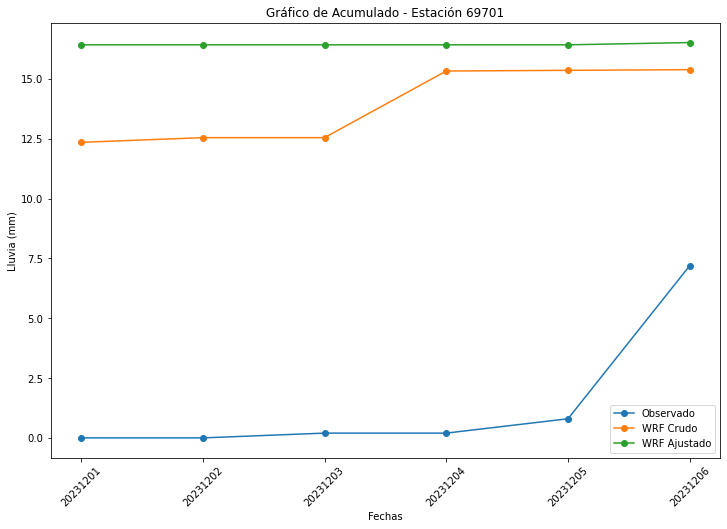

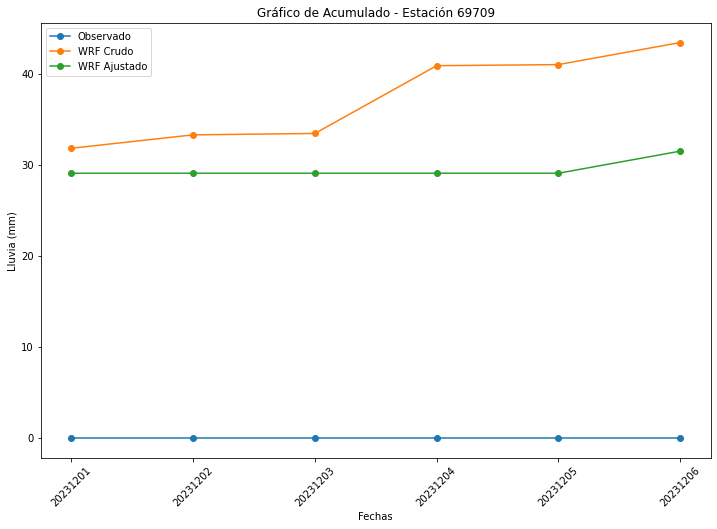

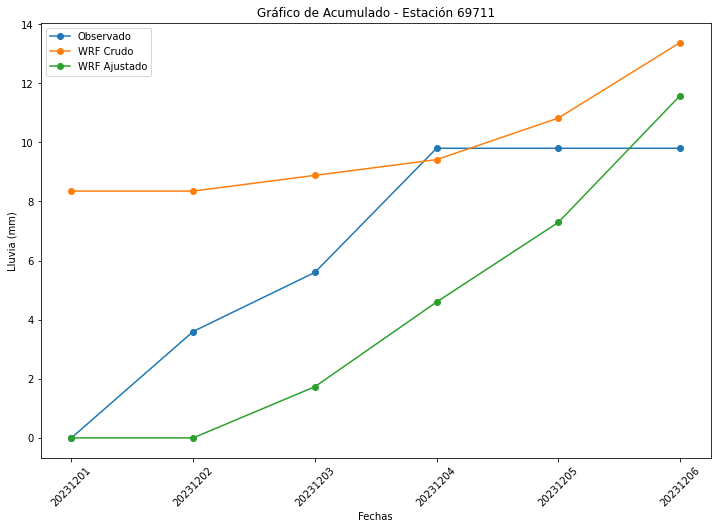

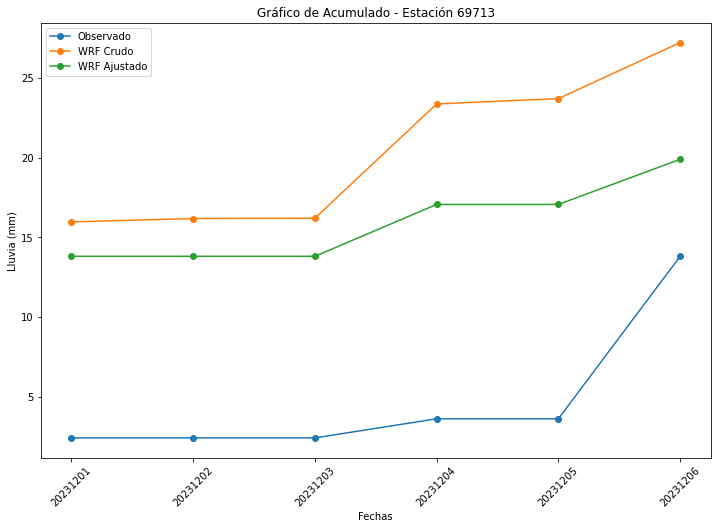

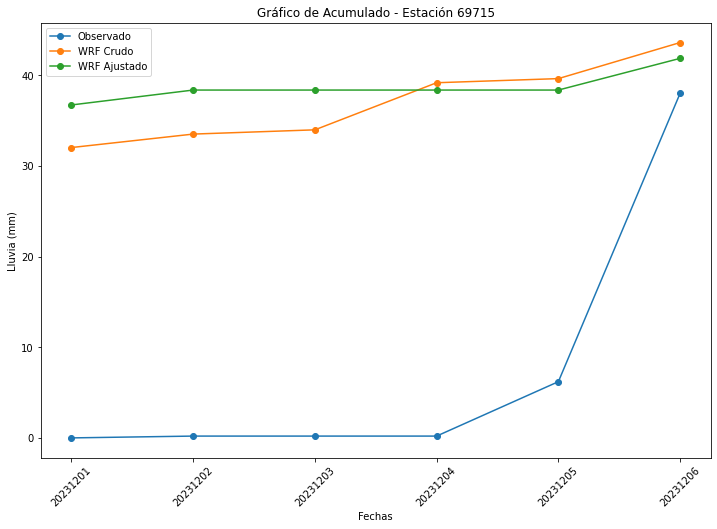

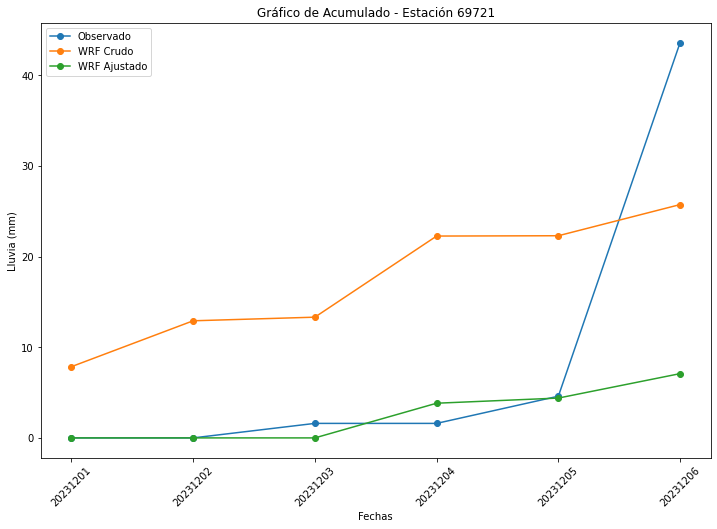

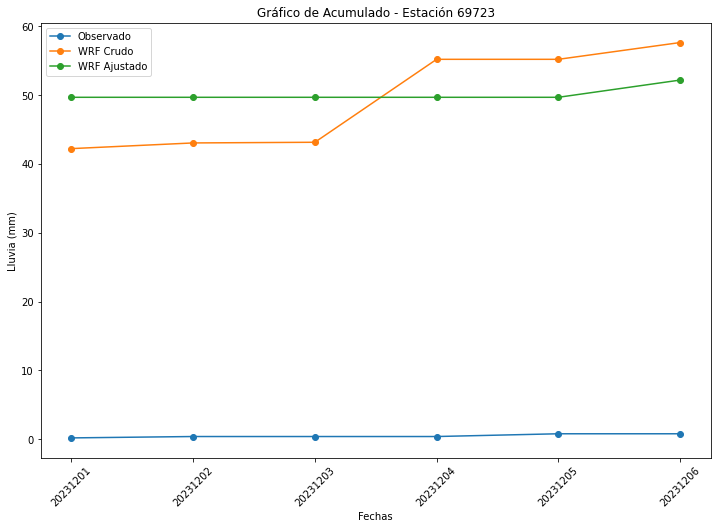

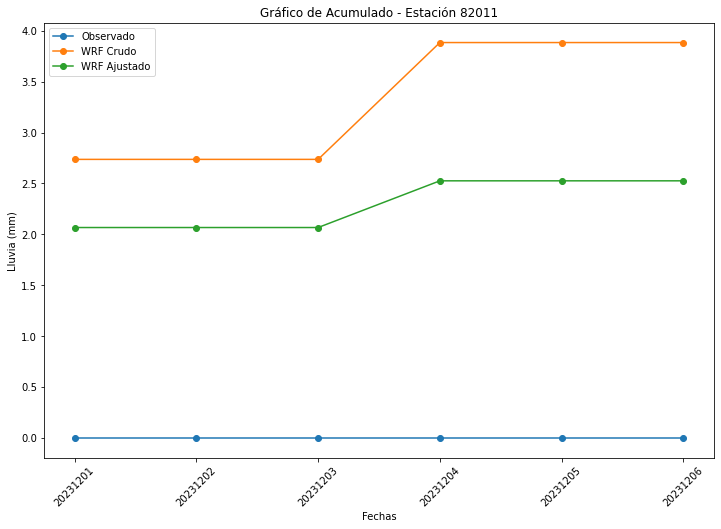

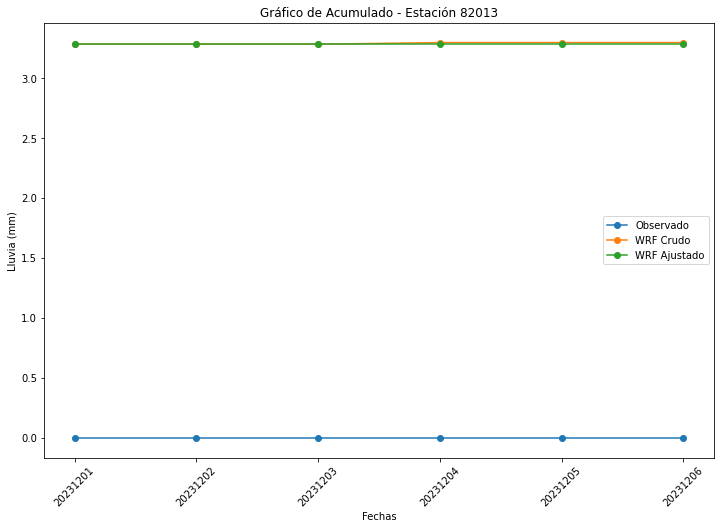

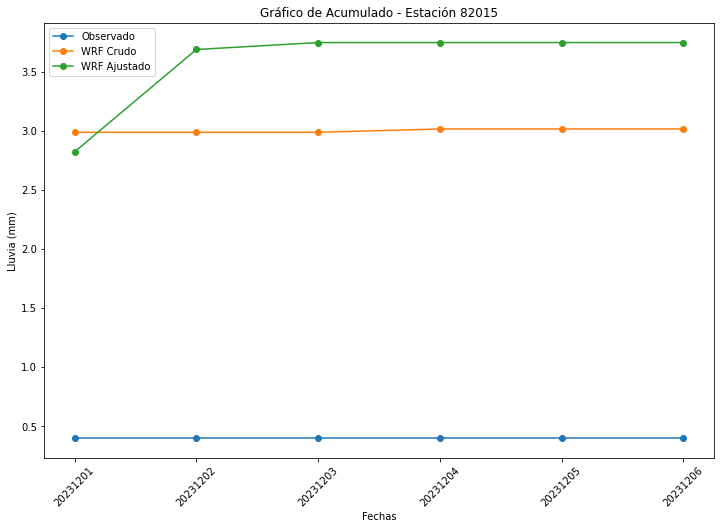

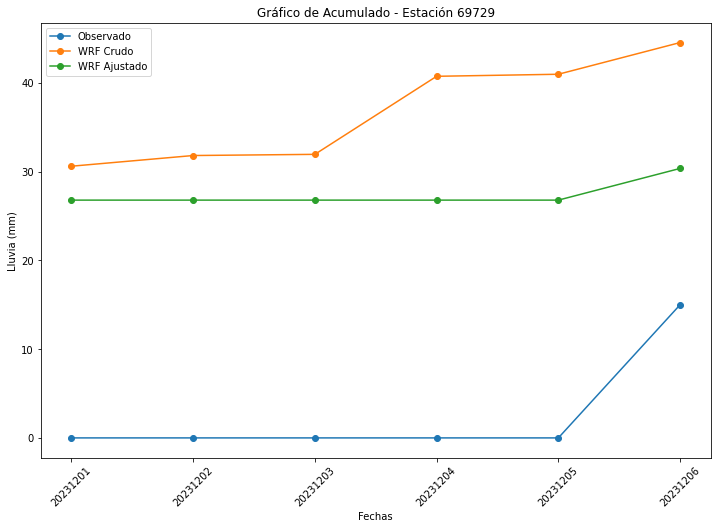

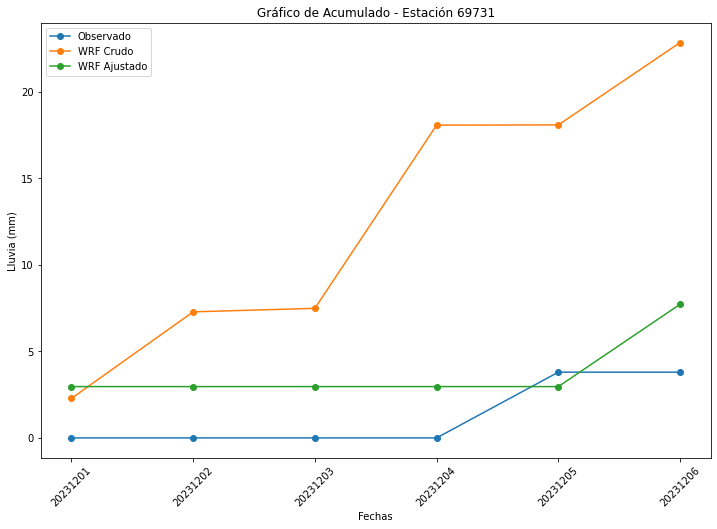

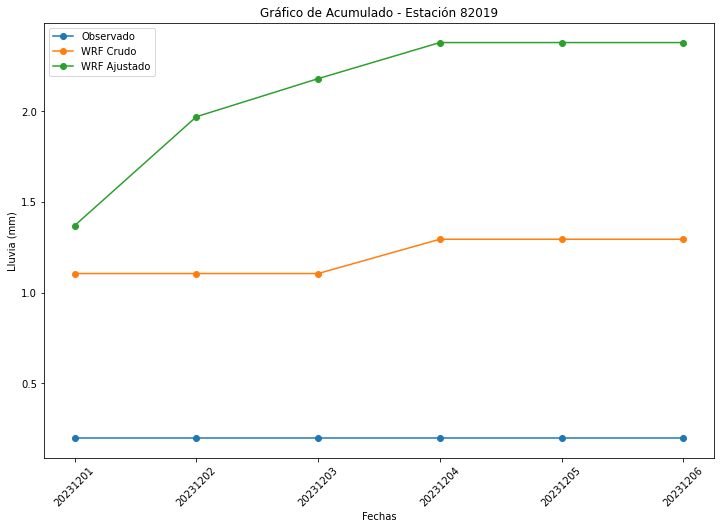

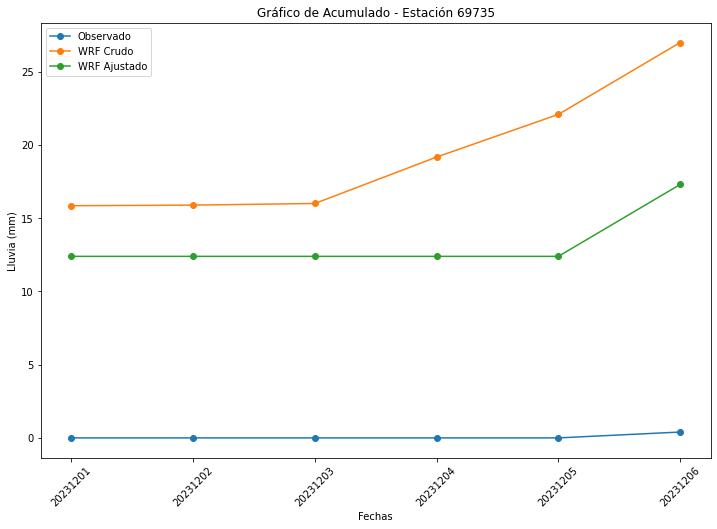

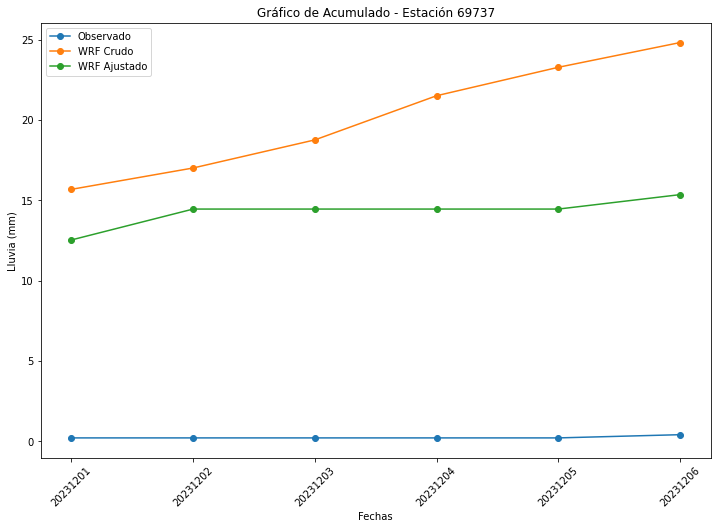

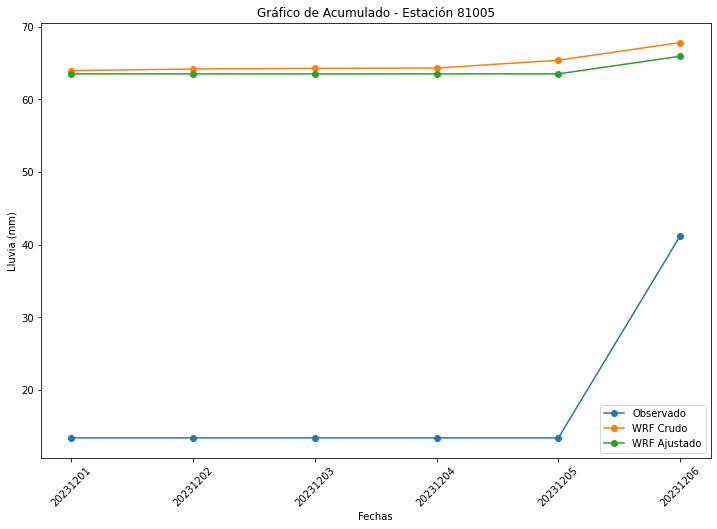

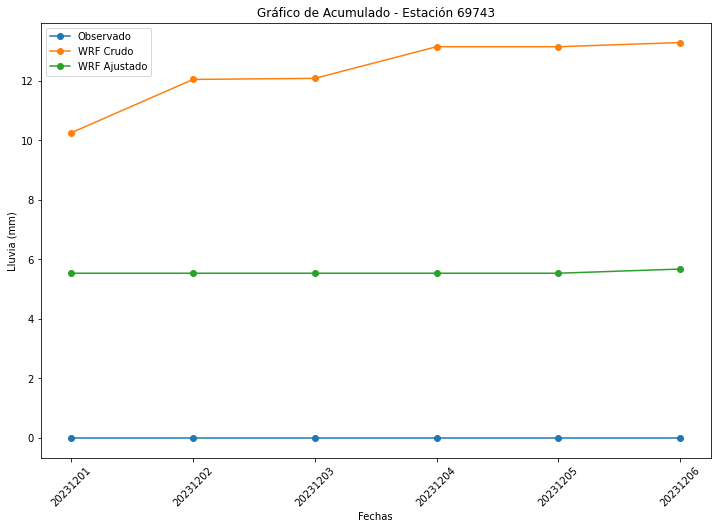

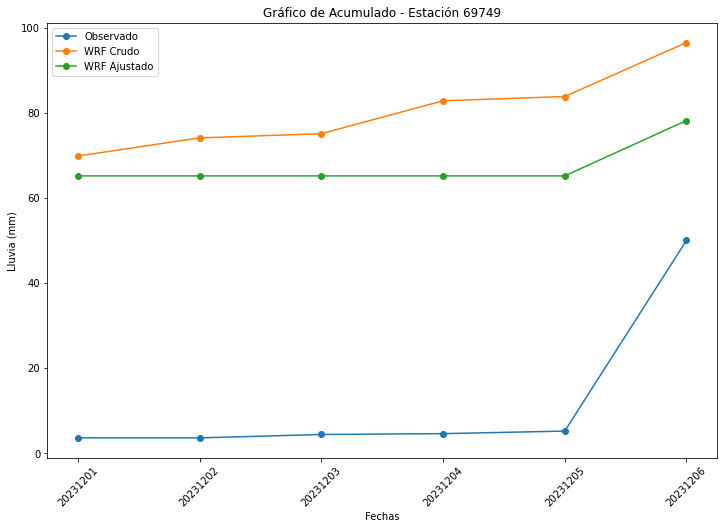

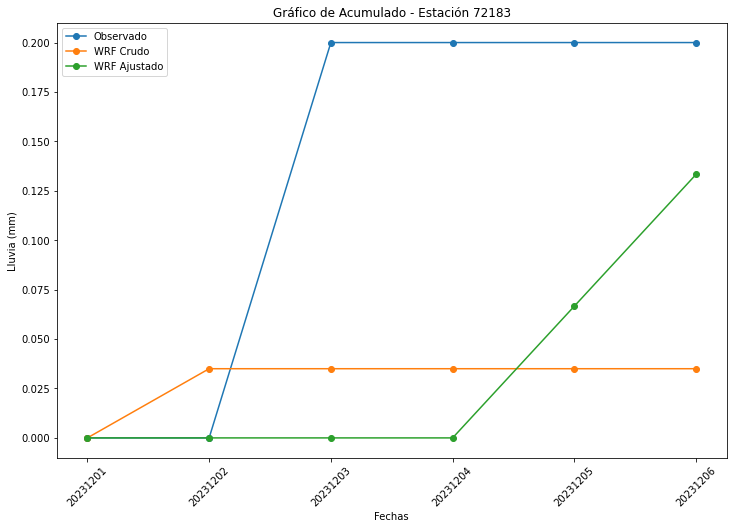

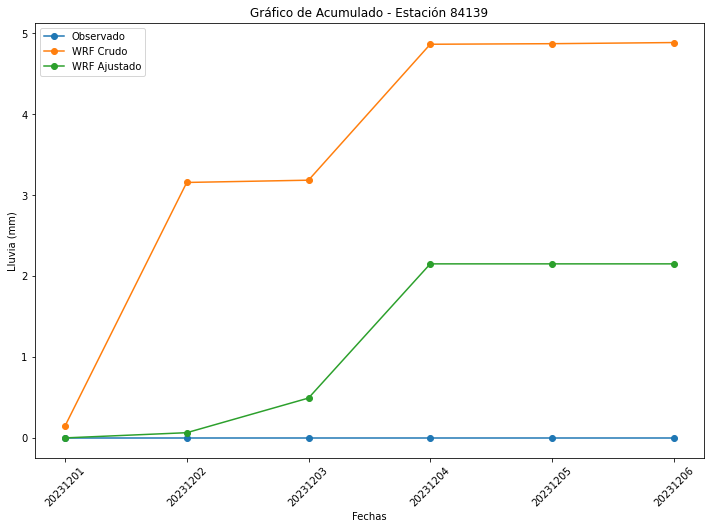

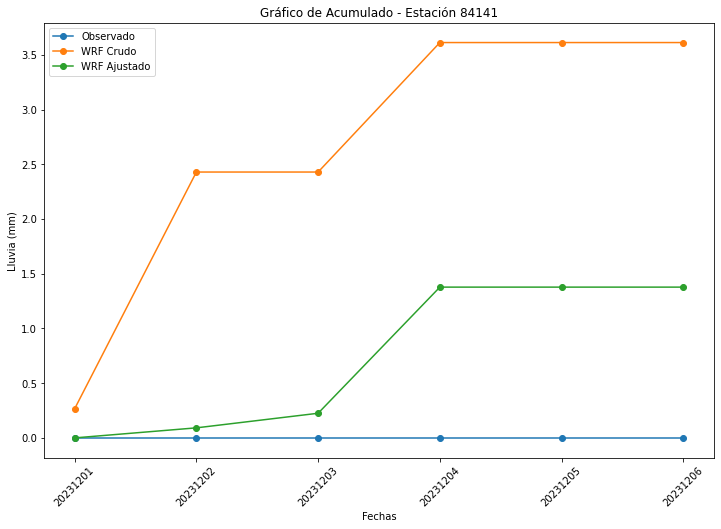

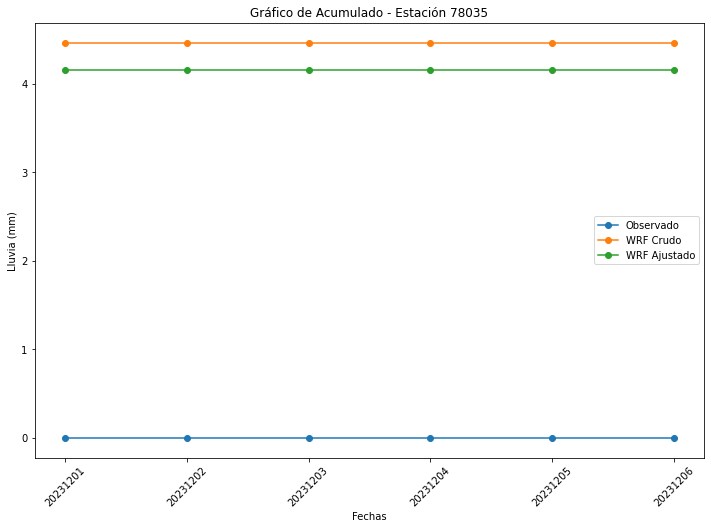

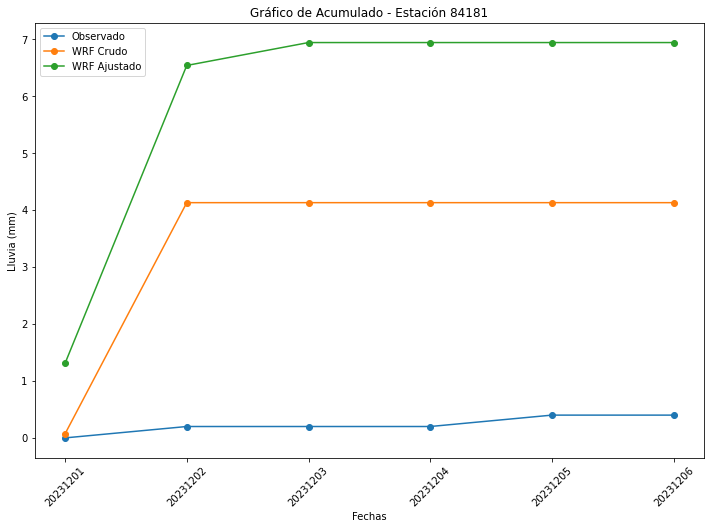

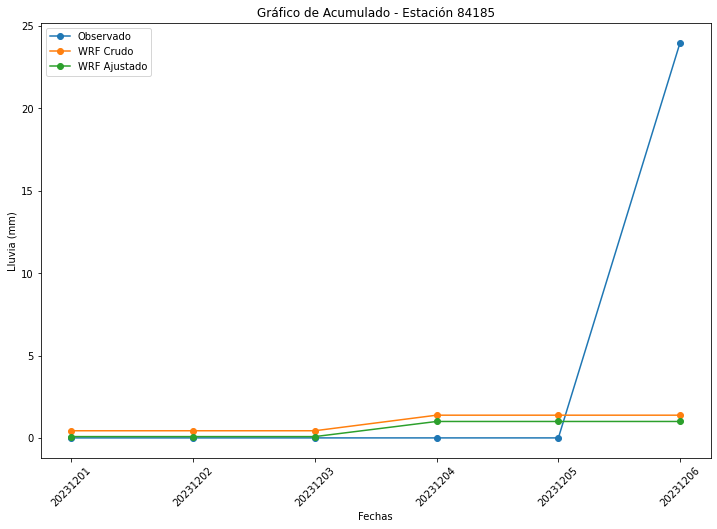

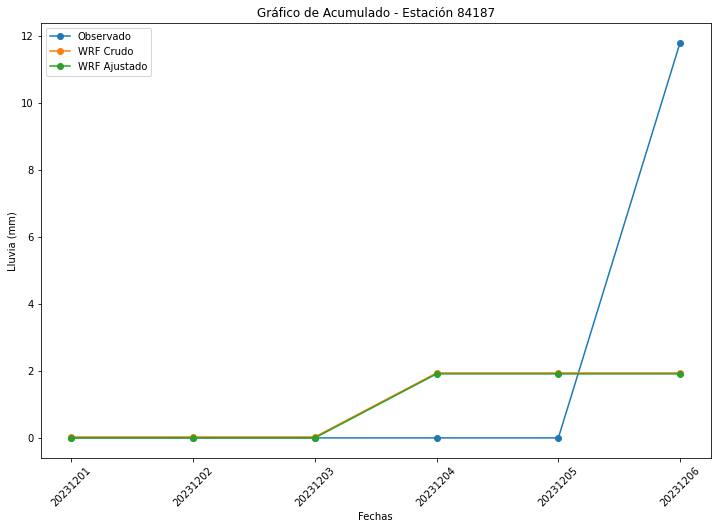

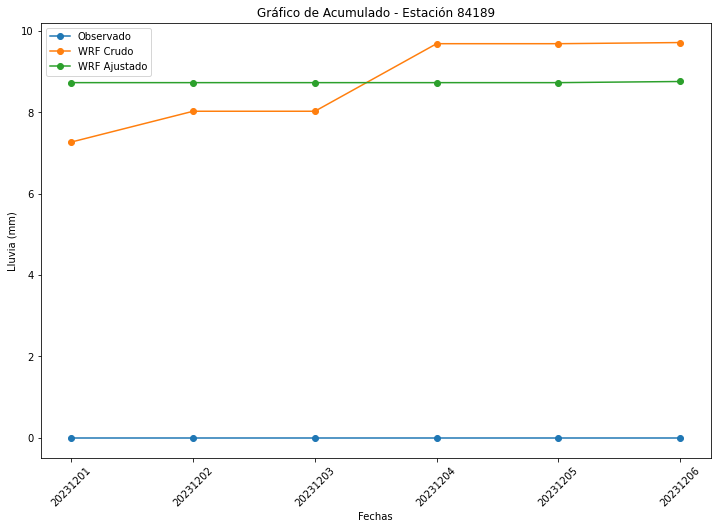

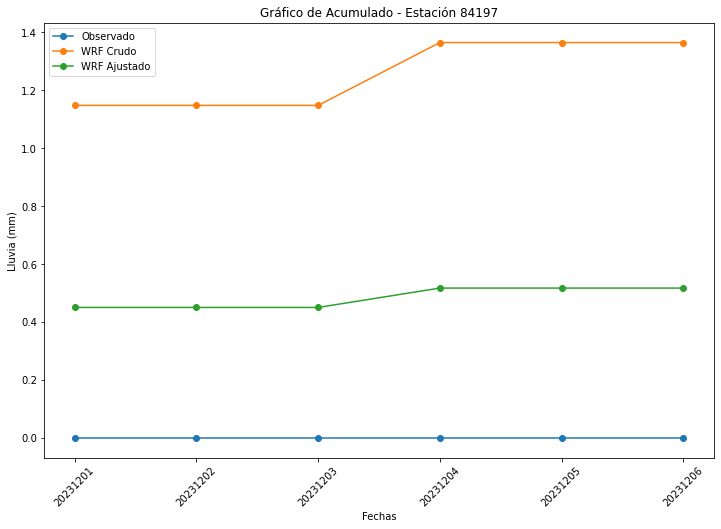

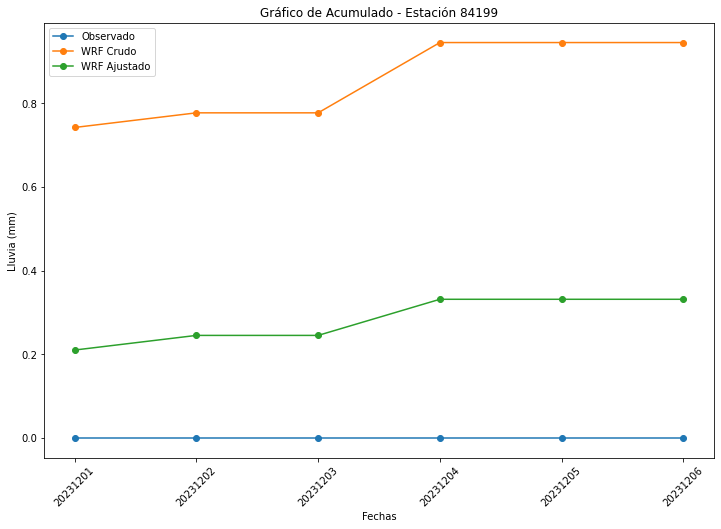

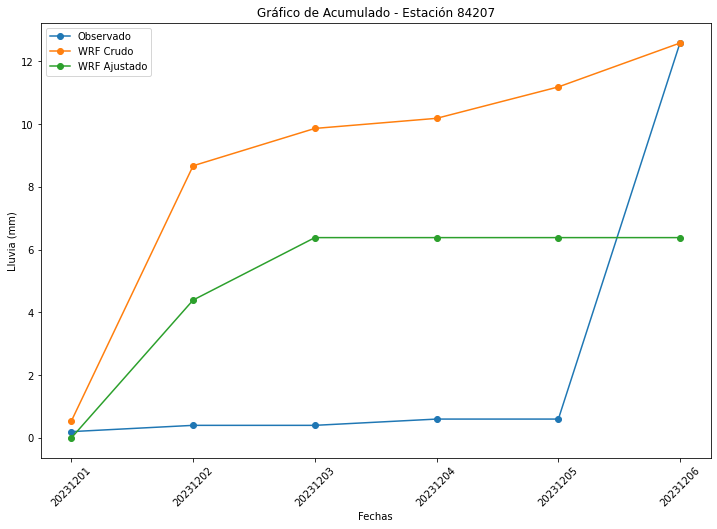

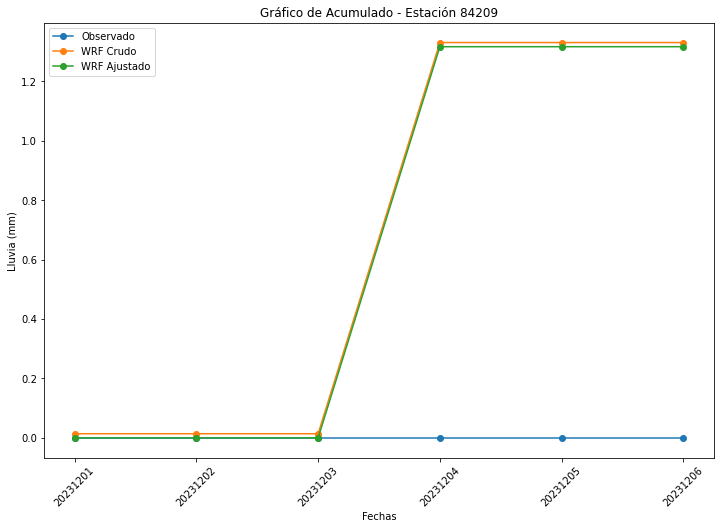

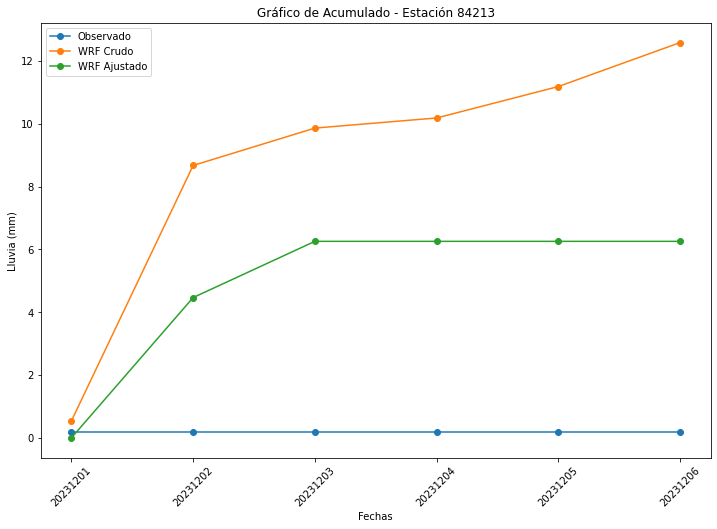

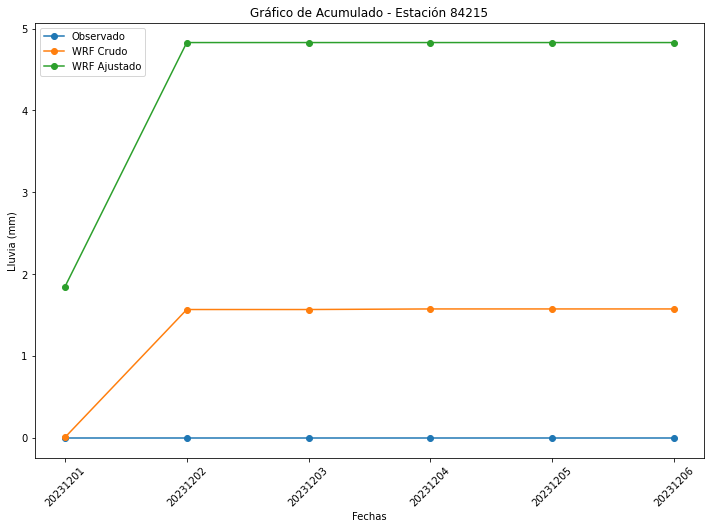

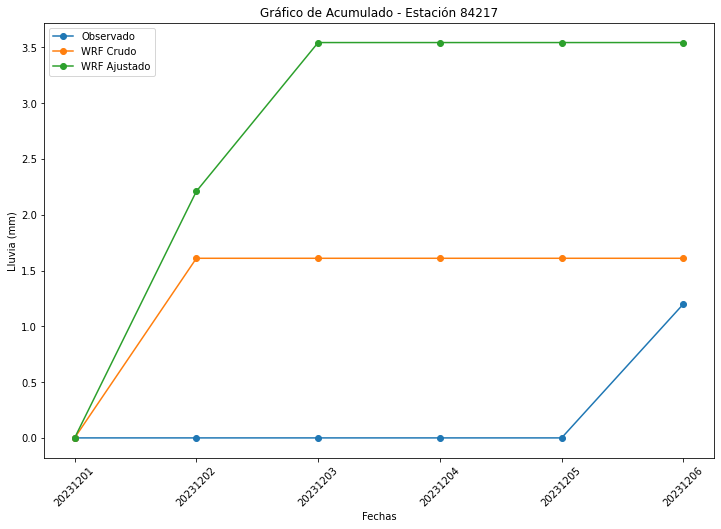

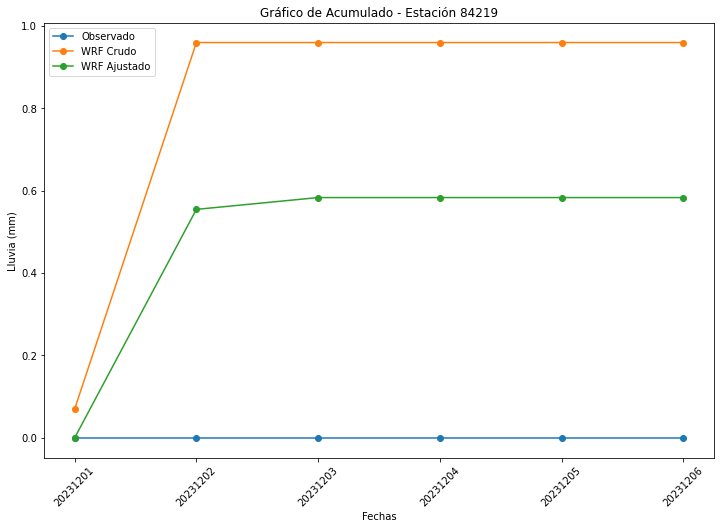

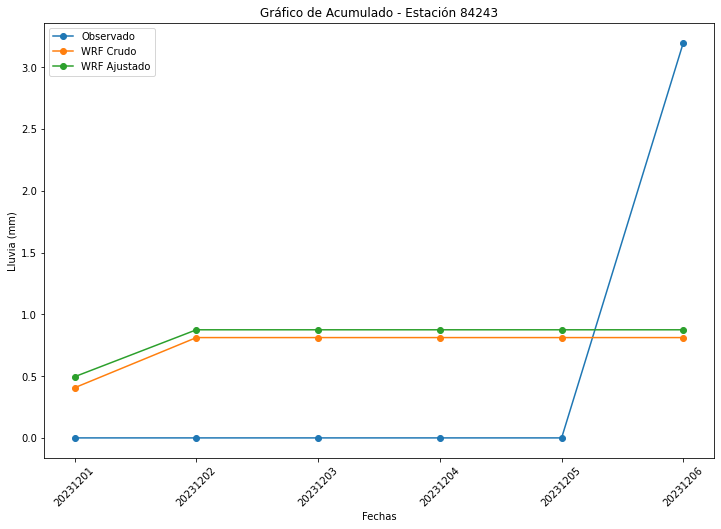

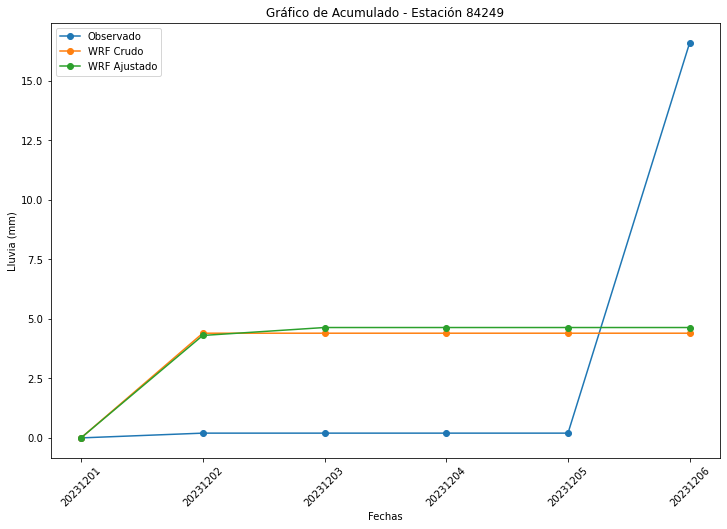

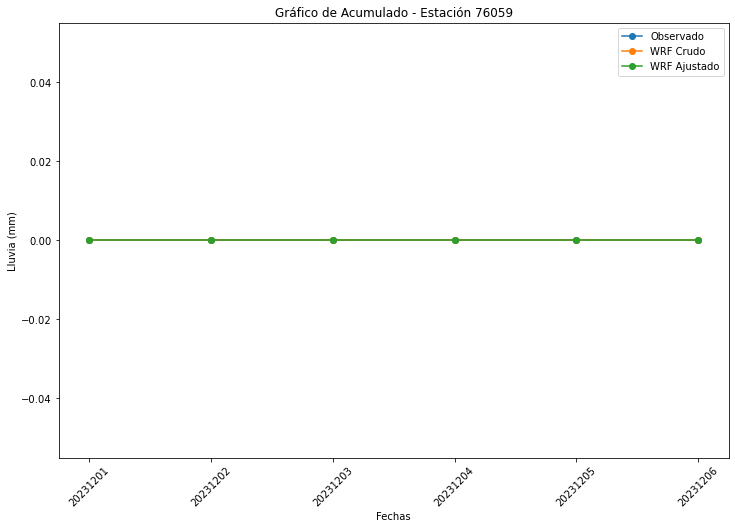

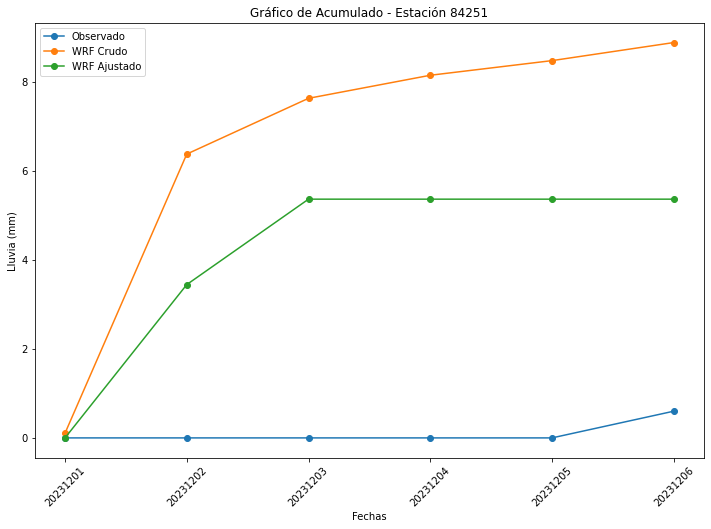

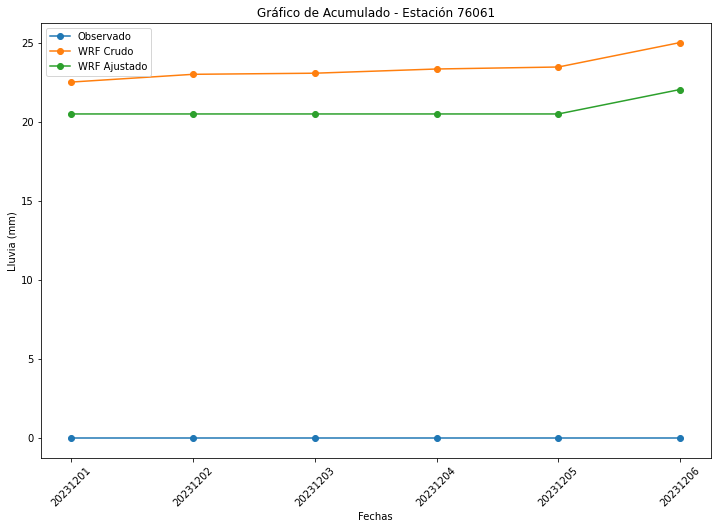

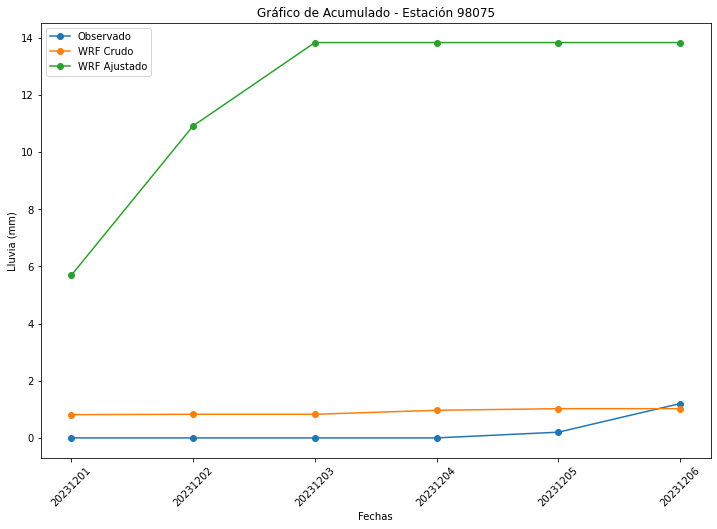

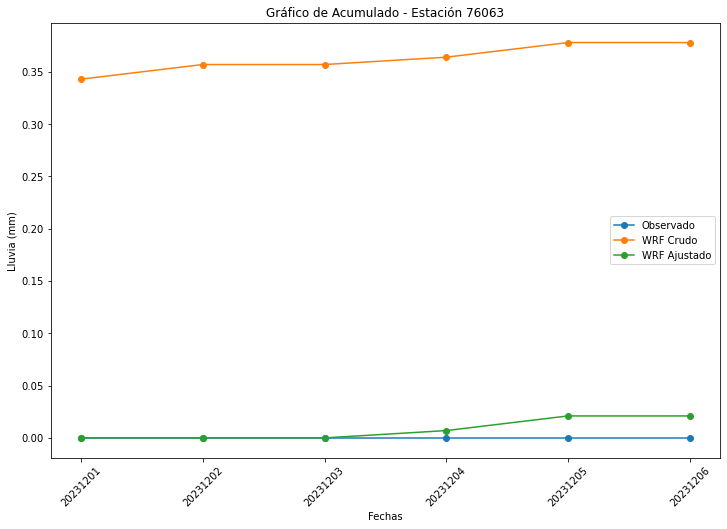

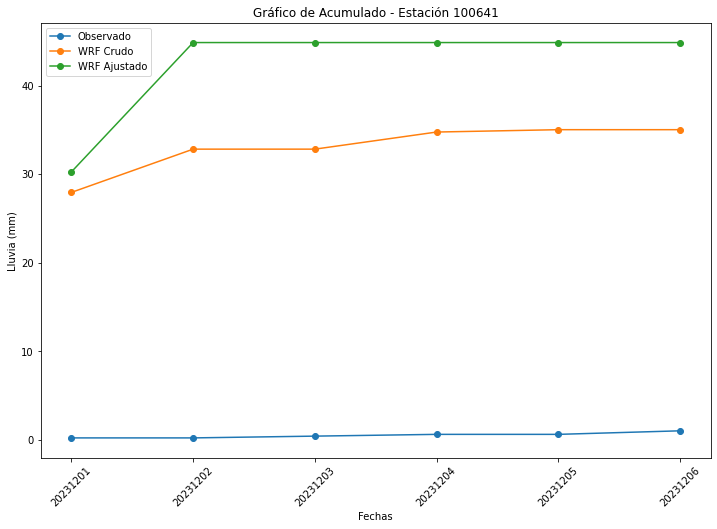

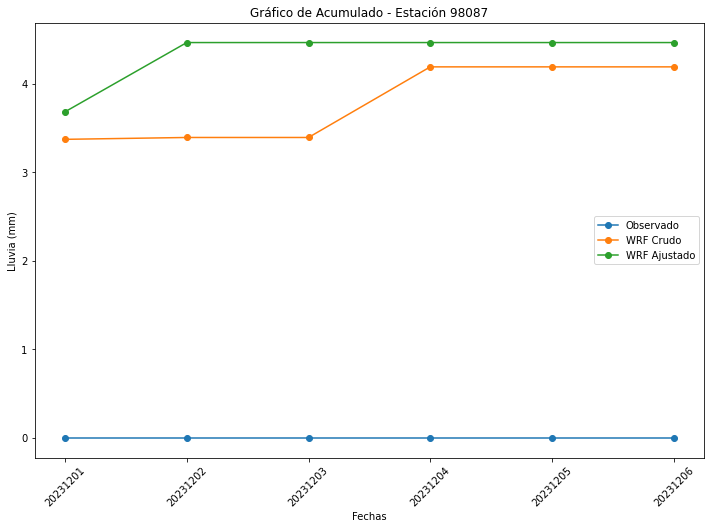

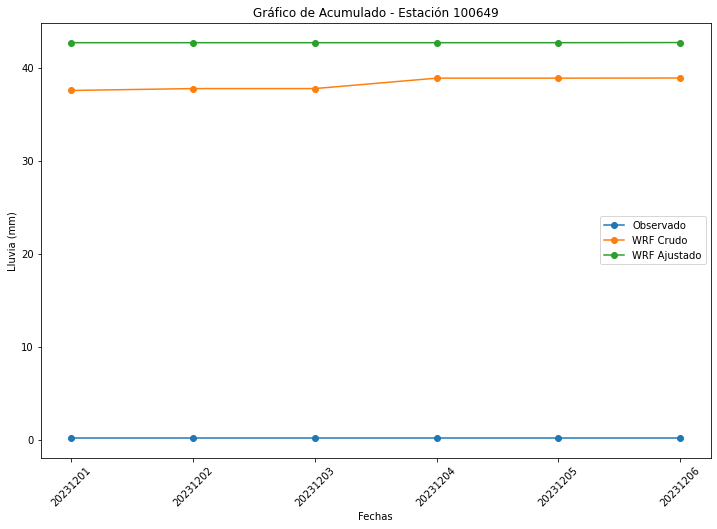

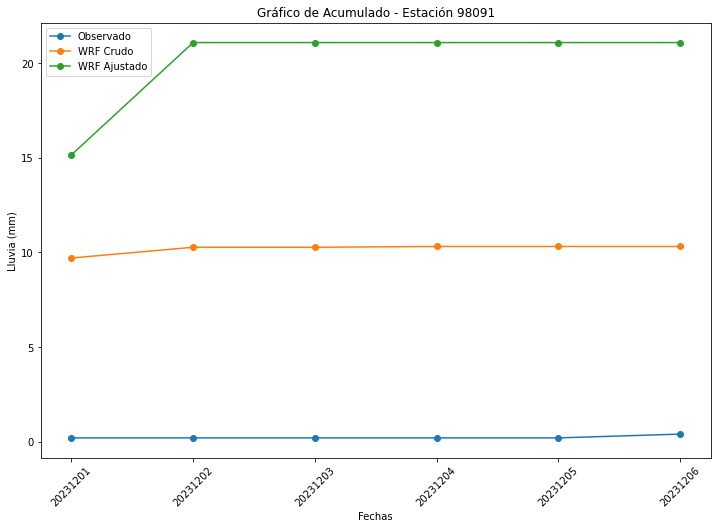

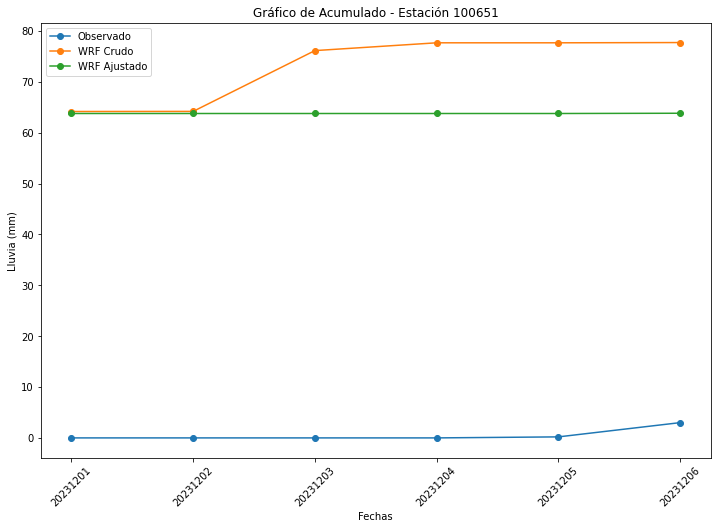

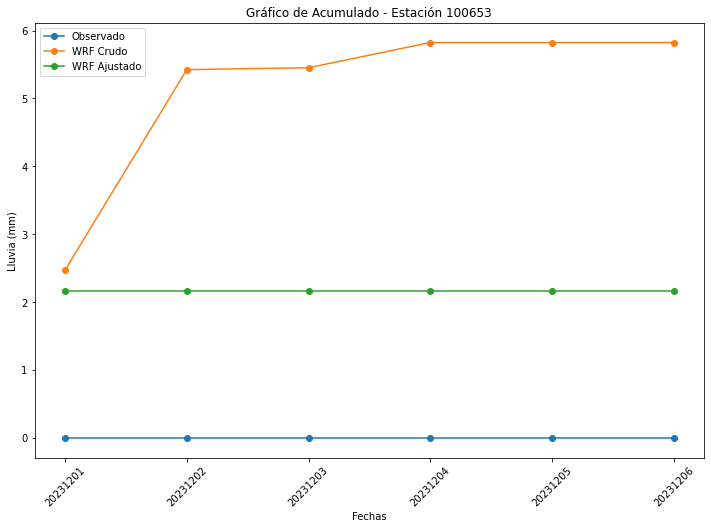

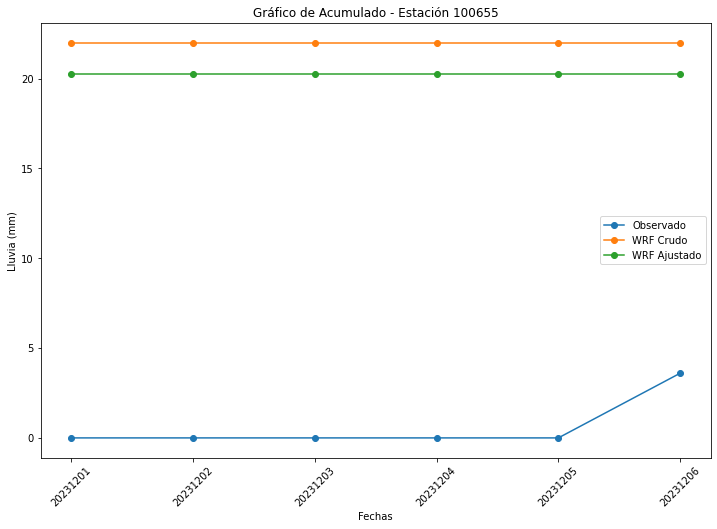

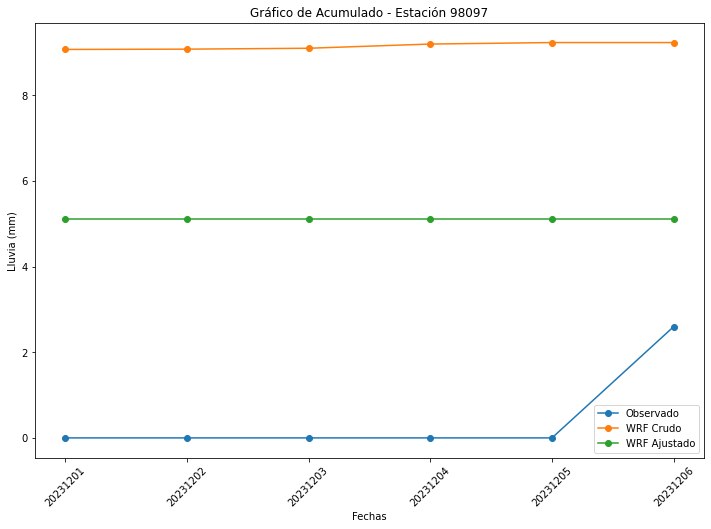

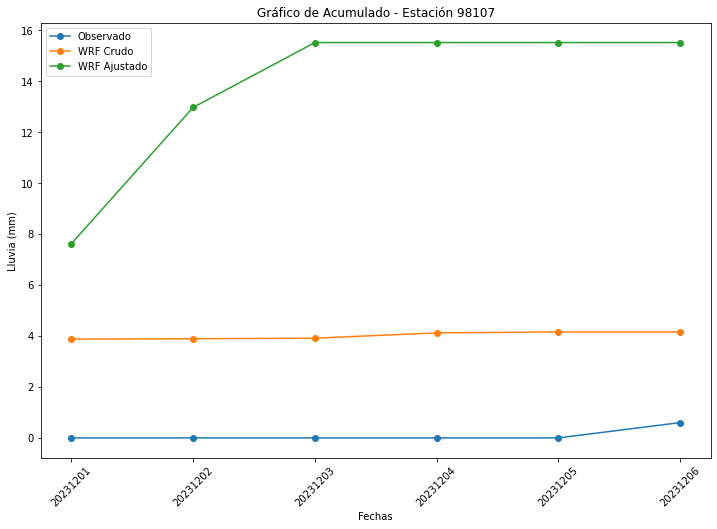

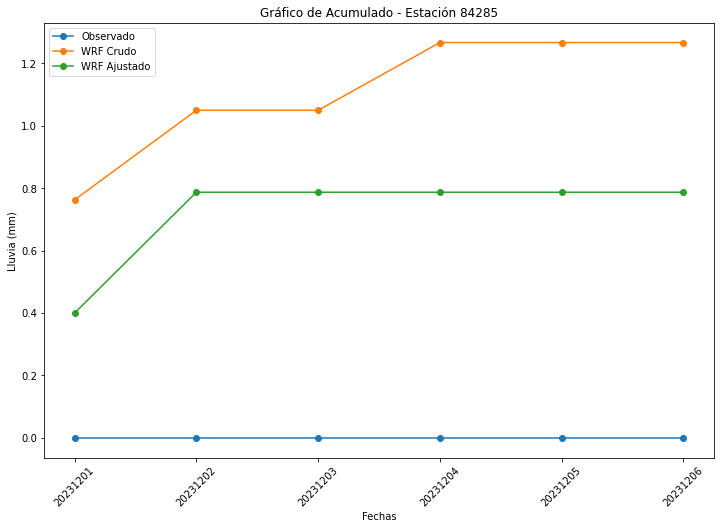

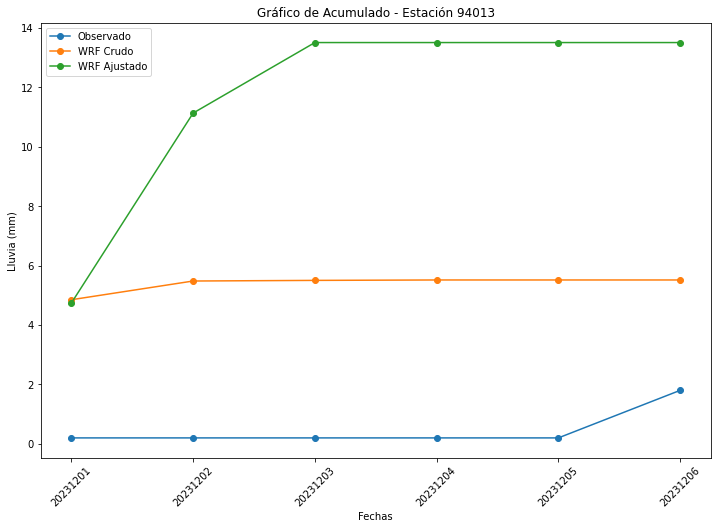

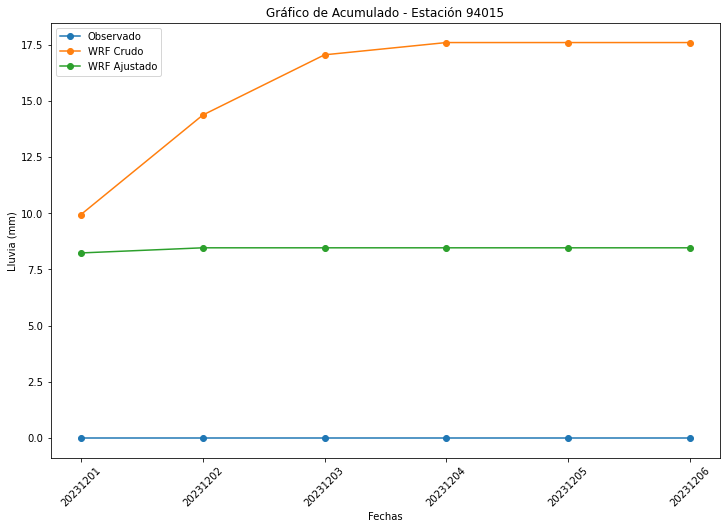

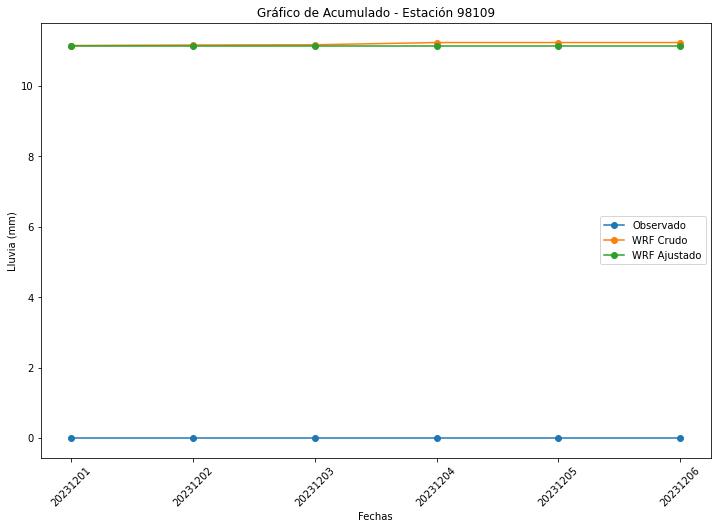

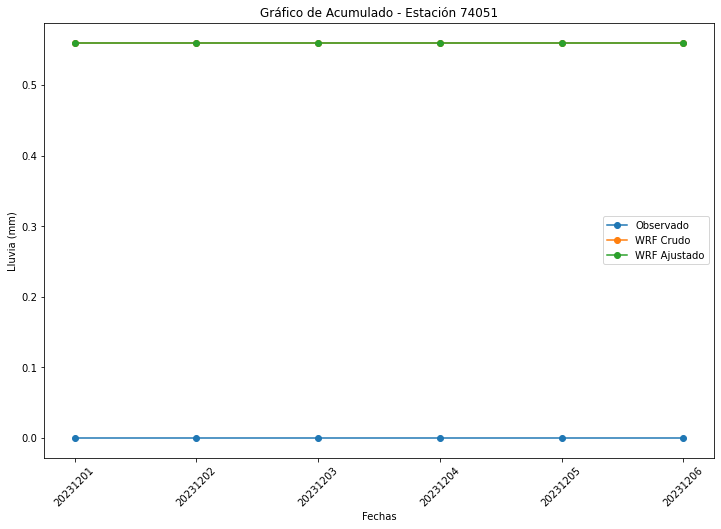

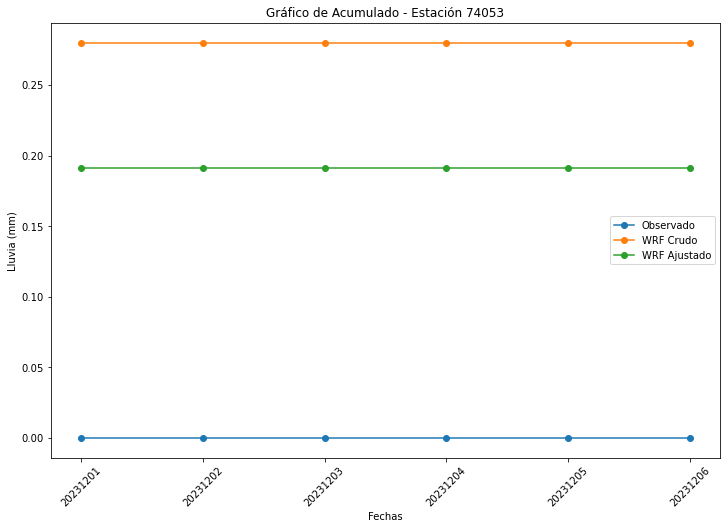

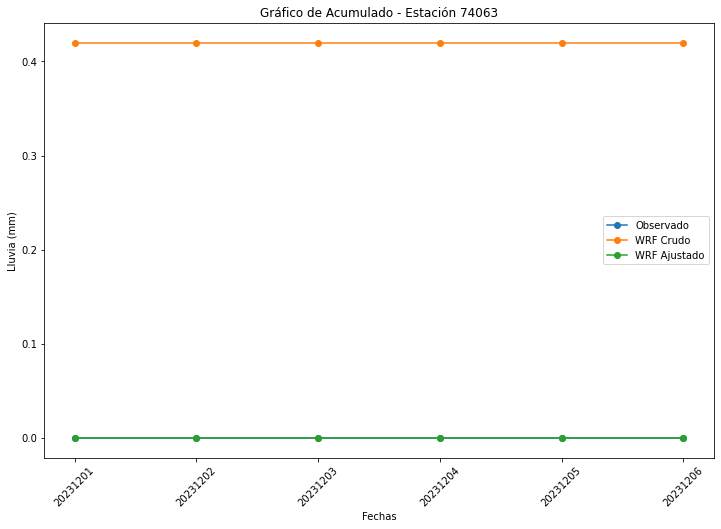

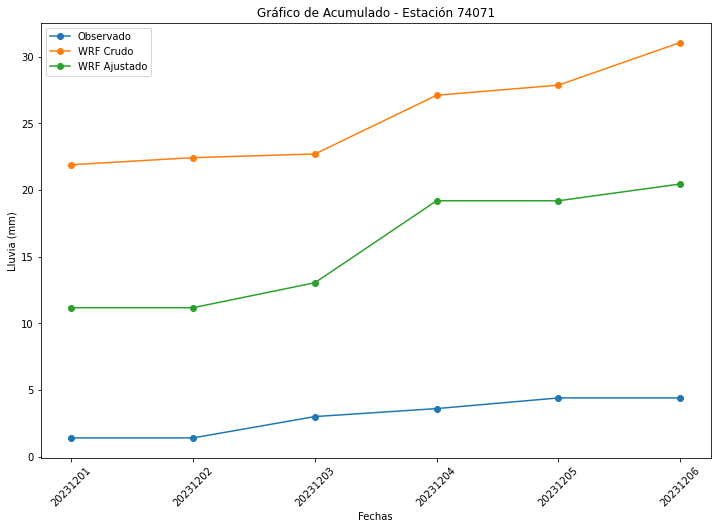

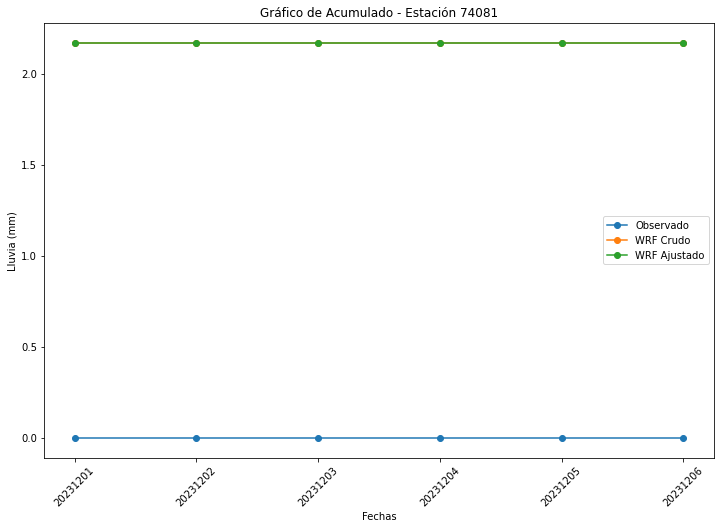

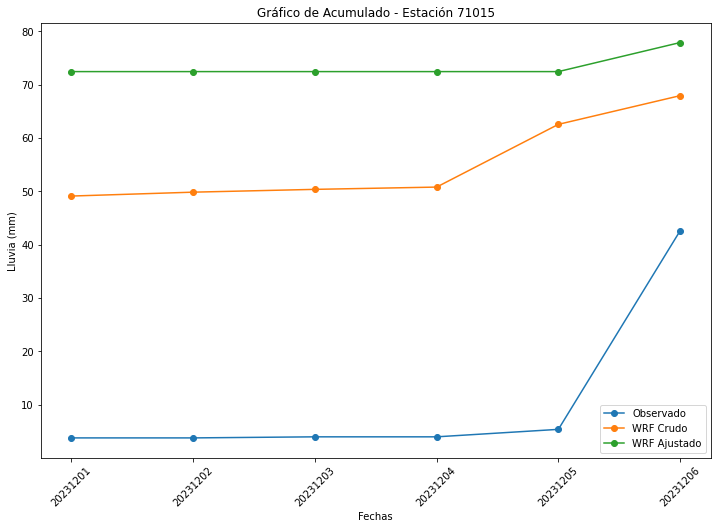

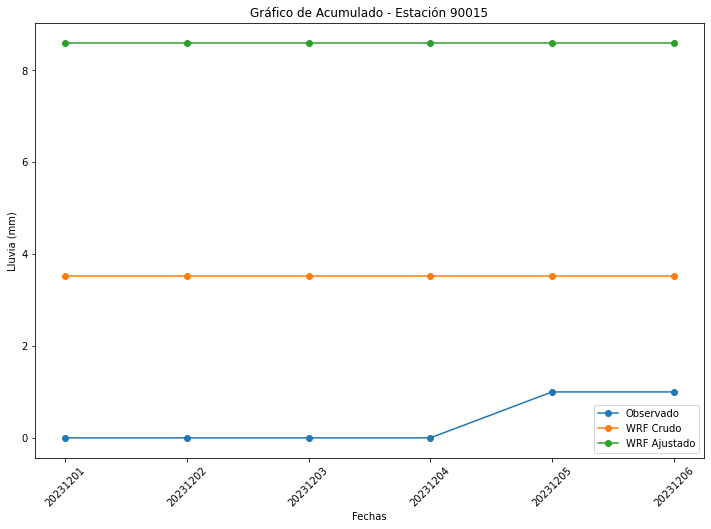

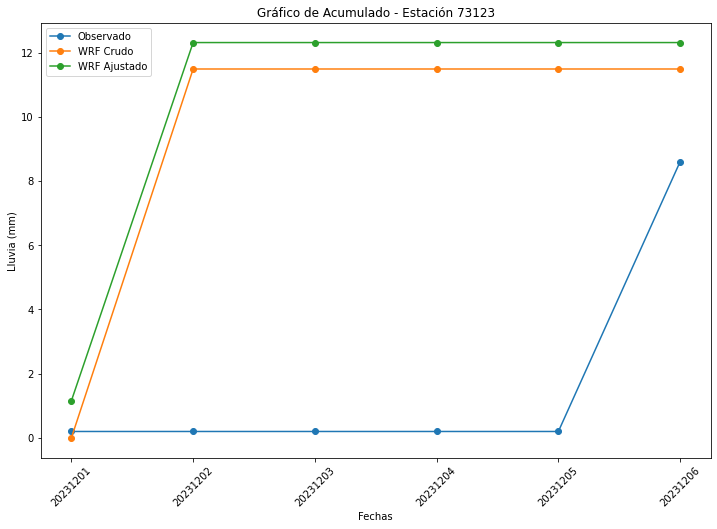

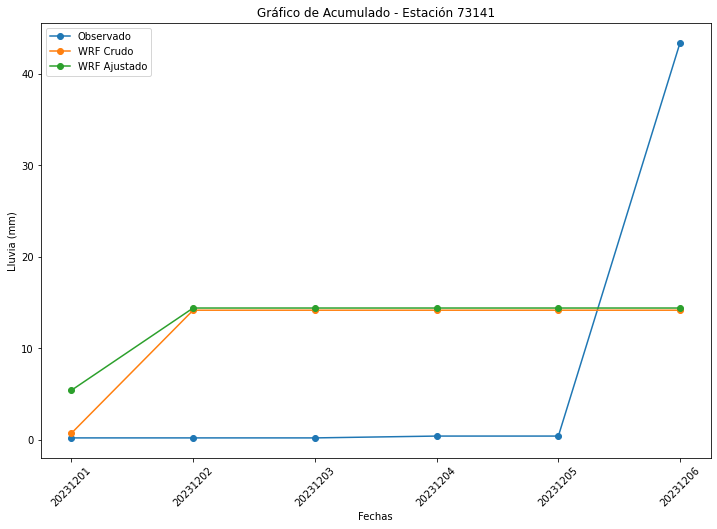

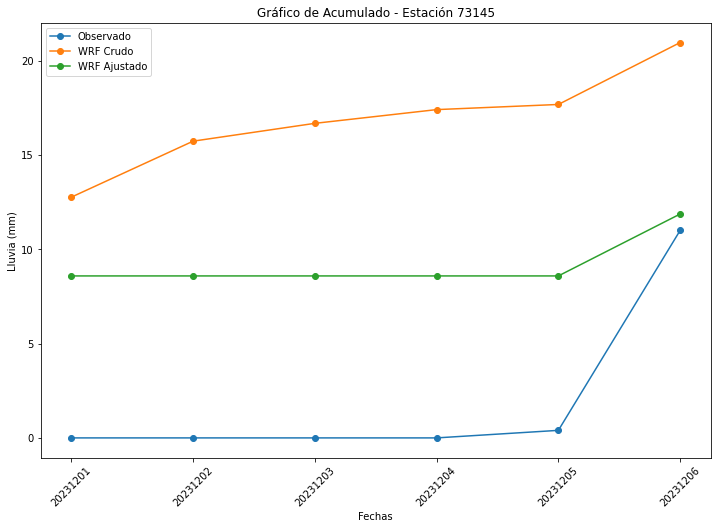

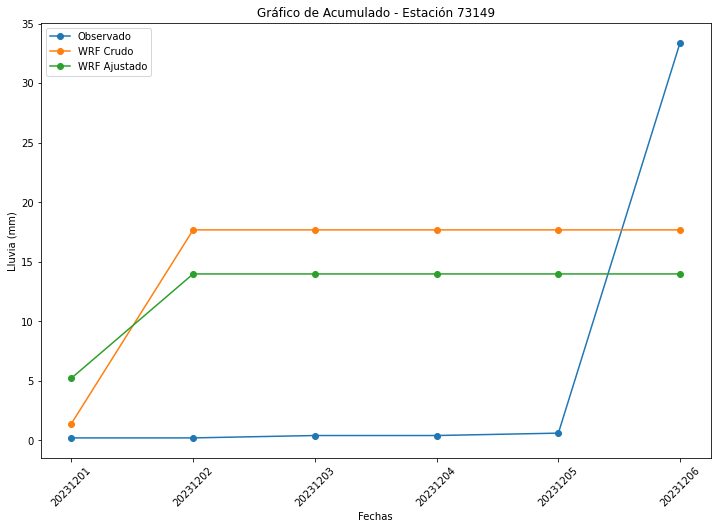

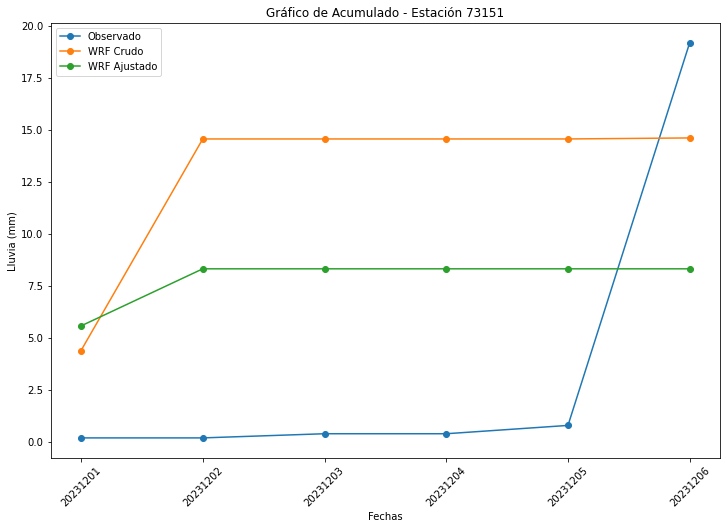

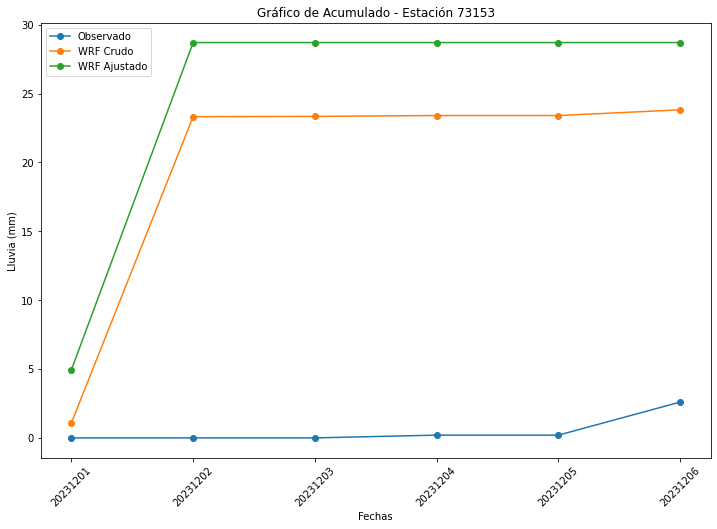

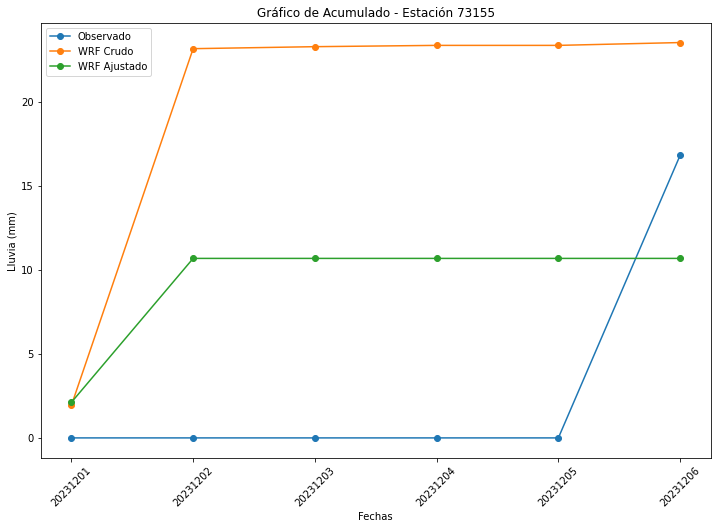

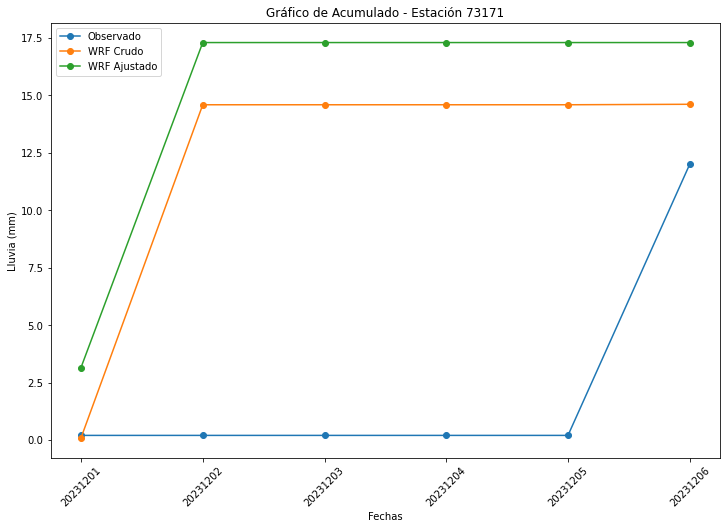

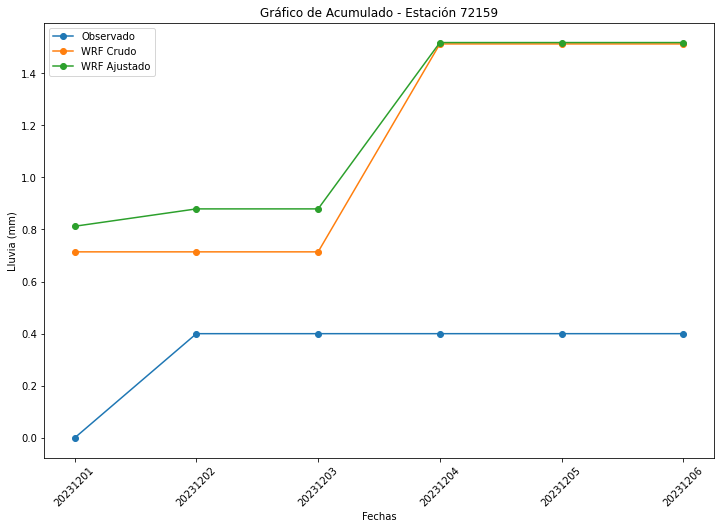

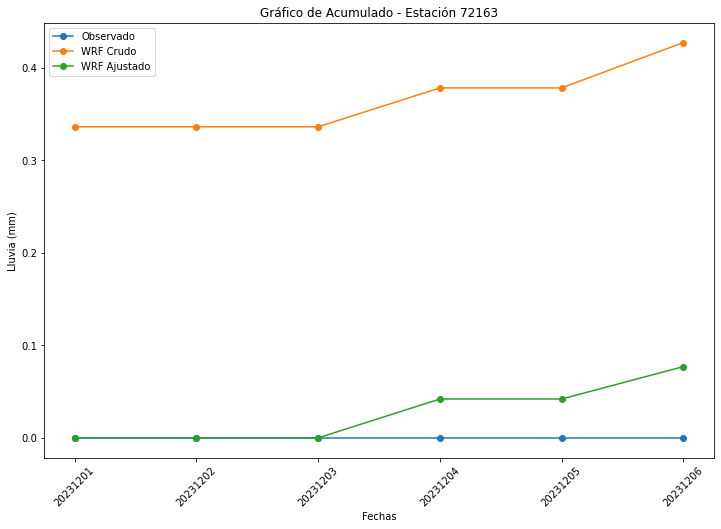

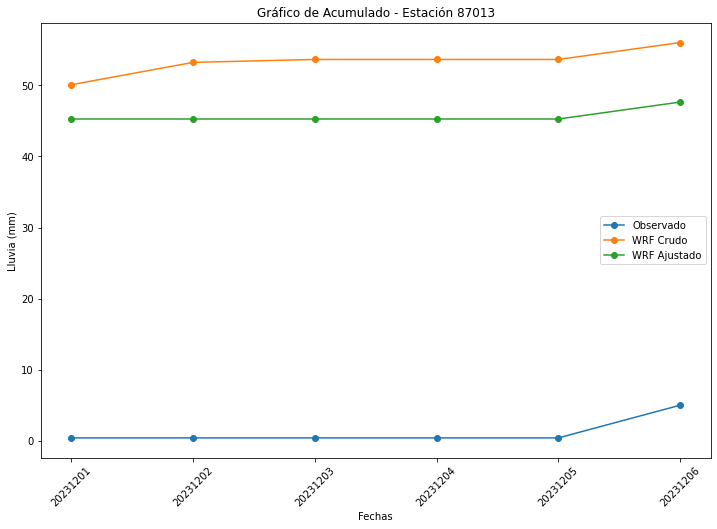

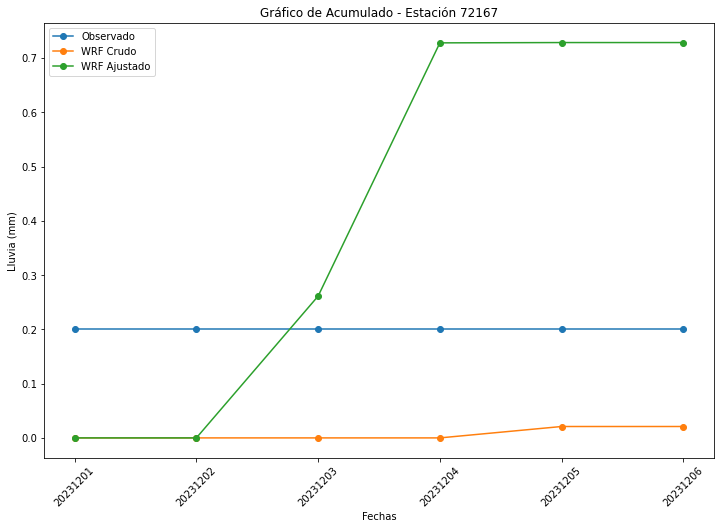

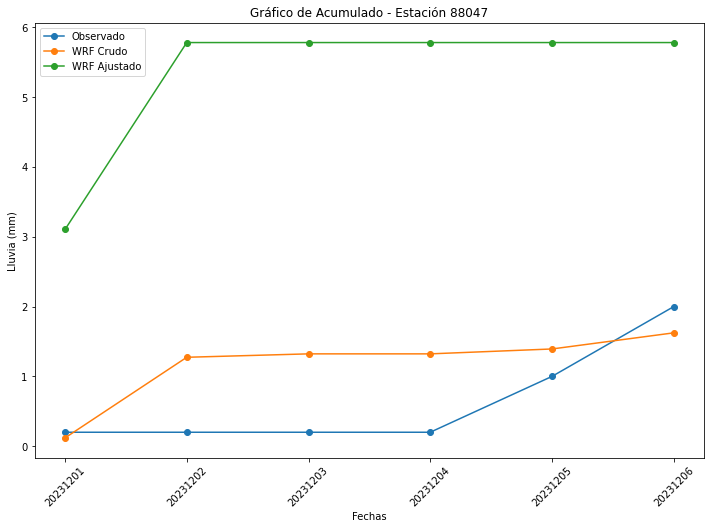

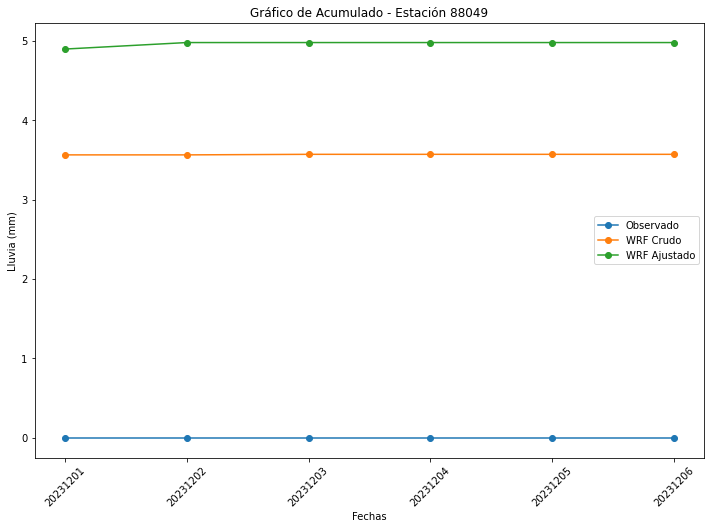

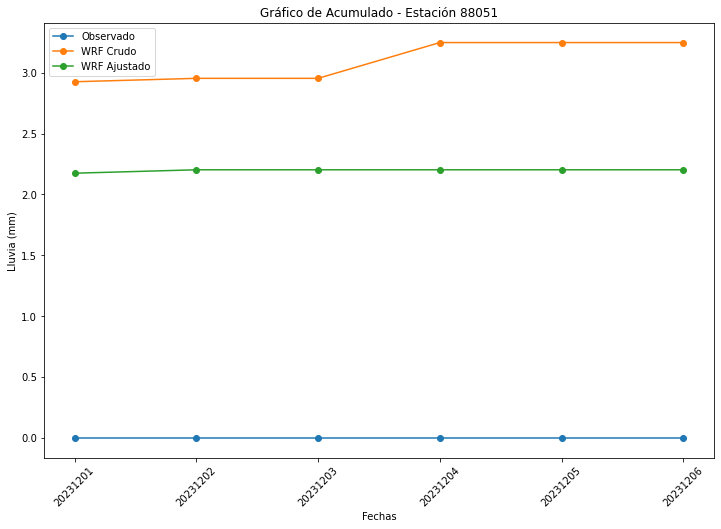

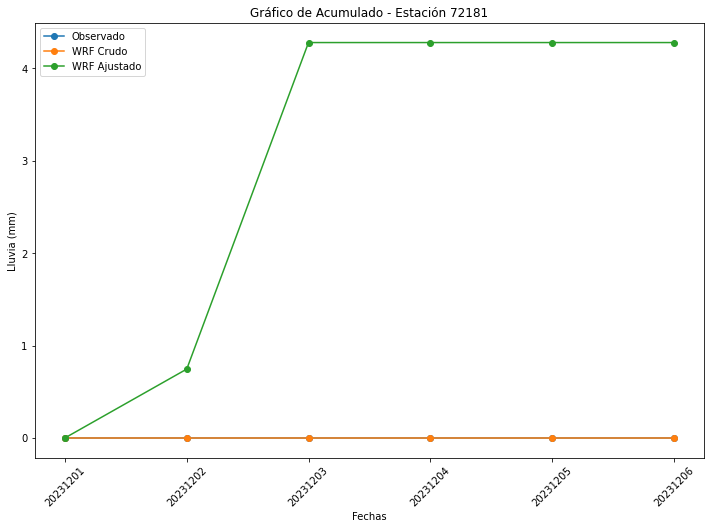

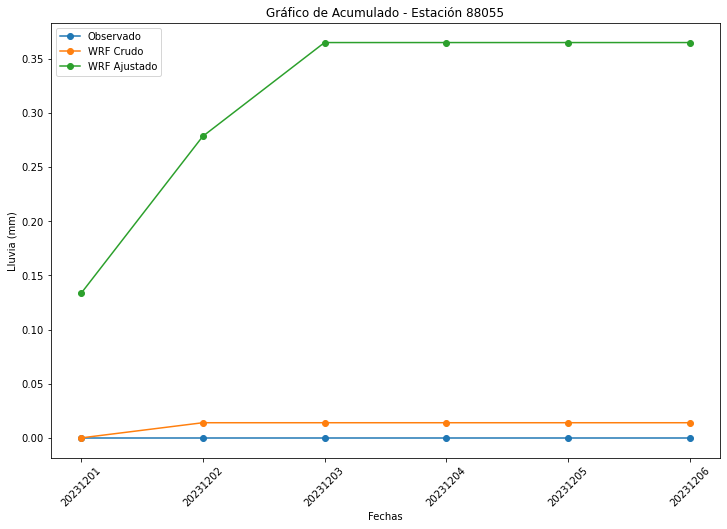

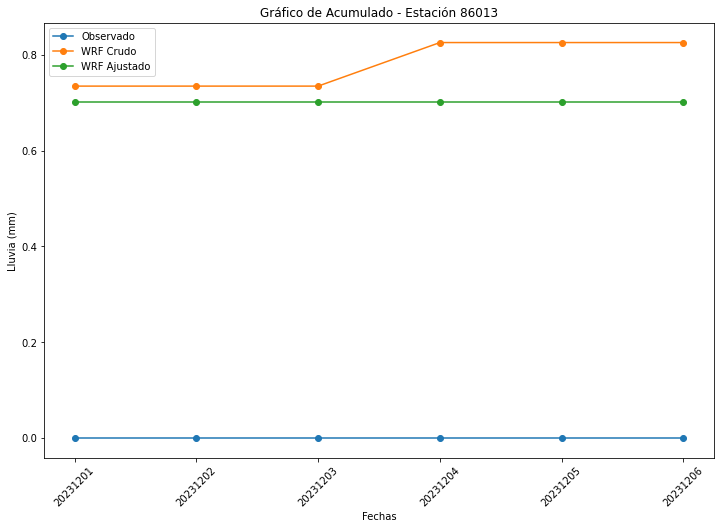

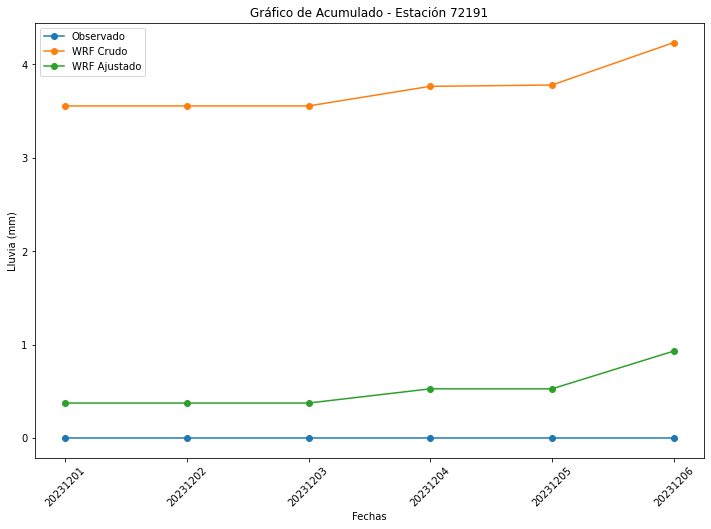

In [222]:
# Rutas de los archivos a verificar
carpeta = r"C:/Users/arias/OneDrive/Documentos/UCR/TFG/Ajuste_Datos/Lluvia"

archivos_a_verificar_lluvia = [
    f"{carpeta}/Datos/Observado/Crudo/{fecha_txt}.lluvia.csv",
    f"{carpeta}/Datos/Modelo/WRF_Crudo/{fecha_txt}.lluvia.csv",
    f"{carpeta}/Datos/Modelo/WRF_Ajustado/{fecha_txt}.lluvia.csv"
]

# Verificar si todos los archivos existen
archivos_faltantes_lluvia = [archivo for archivo in archivos_a_verificar_lluvia if not os.path.exists(archivo)]

if not archivos_faltantes_lluvia:
    # Importa las funciones y realiza el procesamiento si todos los archivos existen
    lluvia_observado = pd.read_csv(archivos_a_verificar_lluvia[0])
    lluvia_pronostico = pd.read_csv(archivos_a_verificar_lluvia[1])
    lluvia_pronostico_ajustado = pd.read_csv(archivos_a_verificar_lluvia[2])
    
    Label = ["Observado", "WRF Crudo", "WRF Ajustado"]

    # Especifica la carpeta de destino donde deseas guardar las gráficas y tablas de Lluvia
    carpeta_lluvia = f"{carpeta}/Graficas/Acumulados" 

    # Crear variables y listas que se utilizaran en las funciones
    tablas_lluvia = [lluvia_observado, lluvia_pronostico, lluvia_pronostico_ajustado] # tablas de datos de lluvia a utilizar
    nombres_acumulado_lluvia = [f"Acumulado_lluvia_observado_{mes}_{ano}", f"Acumulado_lluvia_pronostico_{mes}_{ano}", f"Acumulado_lluvia_pronostico_ajustado_{mes}_{ano}"]

    # Llamar la función para crear o abrir tablas para almacenar los datos de lluvia que se van a graficar
    acumulados_lluvia = crear_tabla_si_no_existe(carpeta_lluvia, nombres_acumulado_lluvia, tablas_lluvia)

    # Llamar la función para editar tablas para almacenar los datos de lluvia que se van a graficar
    acumulados_lluvia = obtener_acumulado_tablas(carpeta_lluvia, fecha_txt, nombres_acumulado_lluvia, tablas_lluvia, acumulados_lluvia)

    # Llamar la función para generar gráficas de los datos de lluvia
    graficar_datos_acumulado_lluvia(carpeta_lluvia, acumulados_lluvia, Label, mes, ano)
    
else:
    print("Los siguientes archivos no existen:")
    for archivo_faltante in archivos_faltantes_lluvia:
        print(archivo_faltante)
    print("Verifica los archivos y asegúrate de que todos estén presentes.")